In [1]:
pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Conversation Structure") \
    .getOrCreate()




Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/14 18:07:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading the Data 

In [3]:
# Path to the files on local disk
wild_path = "/Users/nicolas/Desktop/MBD/WildChat"
lmsys_path = "/Users/nicolas/Desktop/MBD/Lmsys"
# Load files into a DataFrame or RDD

wild_df = spark.read.parquet(wild_path)
lmsys_df = spark.read.parquet(lmsys_path)

In [4]:
from pyspark.sql.functions import col

wild_df.show(5)
#wild_df.printSchema()
# Check for duplicate conversation_hash
duplicate_conversation_hashes = wild_df.groupBy("conversation_hash").count().filter(col("count") > 1)
print(duplicate_conversation_hashes.count())
# Show the duplicate conversation_hashes
duplicate_conversation_hashes.show()

+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+
|   conversation_hash|             model|          timestamp|                     conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|
+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|             [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United States|f96c8515aa663db23...|{en-US,en;q=0.9, ...|
|b9af1406a2f1593d7...|gpt-3.5-turbo-0613|202

25/01/14 18:08:00 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


2868


+--------------------+-----+
|   conversation_hash|count|
+--------------------+-----+
|d2828d98a3f39460e...|    2|
|157c5b0ee4e781c2c...|    2|
|44e967e3f60985bb9...|    2|
|e9cd58fb02b45fbef...|    4|
|0f431f347e14f82c1...|    2|
|cdfdb70343eb3f5f5...|    2|
|da5b11de190df7844...|    2|
|f0e34271ab18225f6...|   17|
|6b1e28006d577b1fe...|    2|
|1ffd0d8eed90200b2...|    2|
|3b747241e4e1bcbec...|    4|
|e90584ba73ebb3e33...|   22|
|05bfbe92b2e37d2e2...|   17|
|d88efa5027f1bd350...|   34|
|7de244023fcdde606...|    2|
|416abe8e430412241...|    2|
|0d841d88630facd4e...|    2|
|f0dda4b2b4b5bb550...|    2|
|3246f32e807344f2d...|    2|
|329181651e66134e6...|    2|
+--------------------+-----+
only showing top 20 rows



In [5]:
from pyspark.sql.functions import max, col

lmsys_df.show(5)
#lmsys_df.printSchema()
max_turn = lmsys_df.agg(max("turn")).collect()[0][0]
print(f"Valeur maximale de la colonne 'turn': {max_turn}")
# Check for duplicate conversation_id
duplicate_conversation_ids = lmsys_df.groupBy("conversation_id").count().filter(col("count") > 1)

# Show the duplicate conversation_ids
duplicate_conversation_ids.show()

+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|     conversation_id|     model|                       conversation|turn|  language|   openai_moderation|redacted|
+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|c20948192699451b8...|vicuna-13b|               [{Given the artic...|   1|   English|[{{false, false, ...|    true|
|8b02aa2df44847a1b...|vicuna-33b|               [{Alright, let's ...|   2|   English|[{{false, false, ...|    true|
|c18f3612fac140cb9...|vicuna-13b|[{あなたが最終更新されたのはいつ...|   5|  Japanese|[{{false, false, ...|   false|
|d1fabb62e3364665a...| llama-13b|               [{You are an AI a...|   1|   English|[{{false, false, ...|    true|
|b2da335248f04e439...| koala-13b|               [{Reescreva esse ...|   1|Portuguese|[{{false, false, ...|   false|
+--------------------+----------+-----------------------------------+----+----------+--

+---------------+-----+
|conversation_id|count|
+---------------+-----+
+---------------+-----+



In [6]:
lmsys_df.select("conversation").show(2, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Joining the two datasets while keeping all the columns 

In [7]:
# Combine the two DataFrames, allowing for missing columns
combined_df = wild_df.unionByName(lmsys_df, allowMissingColumns=True)

# Show the combined DataFrame
combined_df.show(20)

25/01/14 18:08:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+
|   conversation_hash|             model|          timestamp|                       conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|conversation_id|
+--------------------+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|               [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United States|f96c8515aa663db23...|{en-US,en;

### Keeping only one column for the conversation ids/hashes 

In [8]:
from pyspark.sql.functions import coalesce

# Create a new column 'conversation_identifier' that contains the non-null value from 'conversation_hash' or 'conversation_id'
combined_df = combined_df.withColumn('conversation_identifier', coalesce(combined_df['conversation_hash'], combined_df['conversation_id']))

# Drop the original columns if you no longer need them
combined_df = combined_df.drop('conversation_hash', 'conversation_id')

# Show the updated DataFrame
combined_df.show(20)

+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+-----------------------+
|             model|          timestamp|                       conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|conversation_identifier|
+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+-----------------------+
|gpt-3.5-turbo-0613|2023-09-13 04:14:27|               [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United States|f96c8515aa663db23...|{en-US,en;q=0.9, ...|   f01a345e668b978b6...|
|gpt-3.5-turbo-0613|2023

### Distribution of conversation lengths (in terms of turns and duration)

In [9]:
%pip install matplotlib
%pip install --upgrade setuptools
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


+-----------------------+---------+
|conversation_identifier|num_turns|
+-----------------------+---------+
|   a2acbe44c4407ba07...|        2|
|   b5eeea7bab5136ad1...|        1|
|   d821aeaef3b7b9575...|        1|
|   dfa0673d159c04303...|        2|
|   32cff4a3fd8705763...|        1|
|   5216fd26d85afc1e2...|        2|
|   5ab9688f08ccb86ac...|        1|
|   f37417dc5f2266b97...|        1|
|   5935b419f10f18810...|        3|
|   98749955536f294f1...|        5|
+-----------------------+---------+
only showing top 10 rows



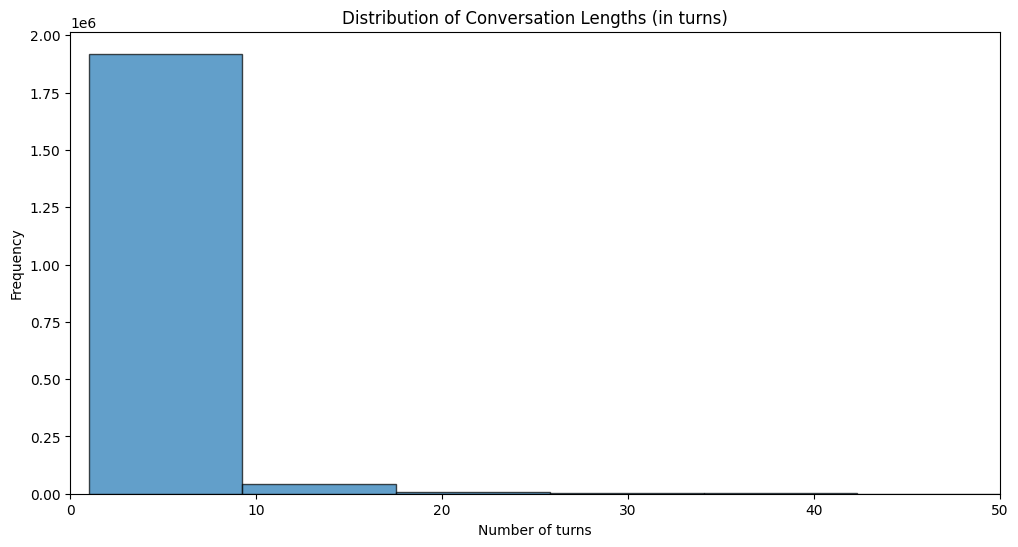

In [10]:

from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, min, max, unix_timestamp, to_timestamp, first, expr

# Ensure the timestamp column is of type TIMESTAMP
combined_df = combined_df.withColumn("timestamp", expr("timestamp"))

# Calculate the number of turns per conversation using the existing 'turn' column
conversation_turns_df = combined_df.groupBy("conversation_identifier").agg(max("turn").alias("num_turns"))


# Show the results
conversation_turns_df.select("conversation_identifier", "num_turns").show(10)


# Visualize the distribution of conversation lengths in turns
# Convert to Pandas DataFrame for visualization
turns_pd_df = conversation_turns_df.select("num_turns").toPandas()


# Plot the distribution of conversation lengths in turns
plt.figure(figsize=(12, 6))
plt.hist(turns_pd_df["num_turns"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Conversation Lengths (in turns)")
plt.xlabel("Number of turns")
plt.ylabel("Frequency")
# Adjust the scales of the graphs
plt.xlim(0, 50)
plt.show()



Proportion of rows with NULL duration: 44.58%


+-----------------------+--------+
|conversation_identifier|duration|
+-----------------------+--------+
|   00004563856f07fdf...|       0|
|   000050a67cb6aeca0...|     681|
|   0001f6ccbfd8329c0...|       0|
|   00020d15dd7ce4035...|     215|
|   000219848e62483da...|       0|
|   0002285d400a6aa3e...|       0|
|   000260c05c7781ba4...|     782|
|   0002a1d969b12fe34...|      10|
|   0002a38e501461184...|     228|
|   0002bc59ffa83bcb0...|       0|
+-----------------------+--------+
only showing top 10 rows



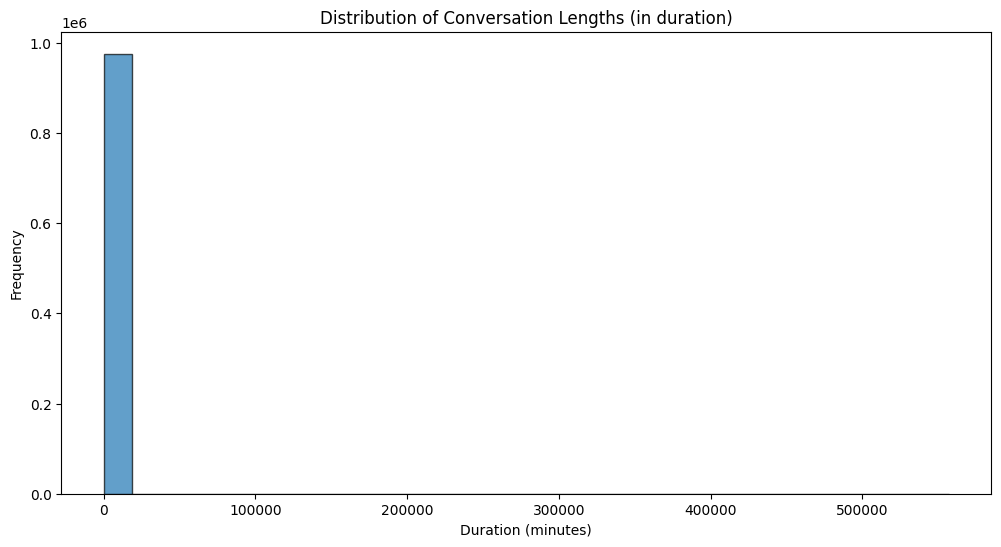

In [11]:
from pyspark.sql.functions import col, min, max, unix_timestamp, explode, to_timestamp
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Explode the conversation array to have one row per message
exploded_df = combined_df.withColumn("message", explode("conversation"))

# Extract the timestamp field from the message column
exploded_df = exploded_df.withColumn("message_timestamp", col("message.timestamp"))

# Convert the message_timestamp to TIMESTAMP type if necessary
exploded_df = exploded_df.withColumn("message_timestamp", to_timestamp(col("message_timestamp")))

# Define the window specification
window_spec = Window.partitionBy("conversation_identifier")

# Calculate the start and end time for each conversation
conversation_duration_df = exploded_df.withColumn("start_time", min("message_timestamp").over(window_spec)) \
                                      .withColumn("end_time", max("message_timestamp").over(window_spec)) \
                                      .withColumn("duration", unix_timestamp(col("end_time")) - unix_timestamp(col("start_time")))

# Calculate the proportion of rows with NULL duration
total_rows = conversation_duration_df.count()
null_duration_rows = conversation_duration_df.filter(col("duration").isNull()).count()
proportion_null_duration = null_duration_rows / total_rows

print(f"Proportion of rows with NULL duration: {proportion_null_duration:.2%}")

# Filter out rows where duration is NULL
conversation_duration_df = conversation_duration_df.filter(col("duration").isNotNull())
# Keep only one row per conversation_identifier by selecting the first occurrence
conversation_duration_df = conversation_duration_df.withColumn("row_number", row_number().over(window_spec.orderBy("start_time"))) \
                                                   .filter(col("row_number") == 1) \
                                                   .drop("row_number")
# Show the results
conversation_duration_df.select("conversation_identifier", "duration").show(10)

# Convert to Pandas DataFrame for visualization
duration_pd_df = conversation_duration_df.select("duration").toPandas()
# Convert duration from seconds to minutes
duration_pd_df["duration"] = duration_pd_df["duration"] / 60

# Plot the distribution of conversation durations in minutes
plt.figure(figsize=(12, 6))
plt.hist(duration_pd_df["duration"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Conversation Lengths (in duration)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
#plt.xlim(0, 20000)
plt.show()


### User message length across different stages of conversation

In [12]:
combined_df.select("conversation_identifier", "timestamp").filter(col("timestamp").isNull()).show()
#combined_df = combined_df.filter(col("timestamp").isNotNull())

+-----------------------+---------+
|conversation_identifier|timestamp|
+-----------------------+---------+
|   c20948192699451b8...|     NULL|
|   8b02aa2df44847a1b...|     NULL|
|   c18f3612fac140cb9...|     NULL|
|   d1fabb62e3364665a...|     NULL|
|   b2da335248f04e439...|     NULL|
|   2dbd0eff0aa543bba...|     NULL|
|   58b648dff2b040d2a...|     NULL|
|   4e211908c506467b8...|     NULL|
|   fb24c174e35149ecb...|     NULL|
|   7a89cf2af95a4fa99...|     NULL|
|   bc82b444362b46969...|     NULL|
|   1073c7201c544d489...|     NULL|
|   289c9947ebe5484ea...|     NULL|
|   46ebfbd78d904561a...|     NULL|
|   c78d9105ad484c71b...|     NULL|
|   2dc4de75be894ef09...|     NULL|
|   afb3f215f7144687b...|     NULL|
|   a06eb9e7de0046508...|     NULL|
|   1e83005a7317490bb...|     NULL|
|   ce8d3b8b273248098...|     NULL|
+-----------------------+---------+
only showing top 20 rows



+-----------+------------------+
|turn_number|avg_content_length|
+-----------+------------------+
|         31| 311.1346278317152|
|         85|198.28985507246378|
|         65| 298.8489932885906|
|         53|335.97610921501706|
|         78|181.23699421965318|
|        108|130.74603174603175|
|         34|248.54909983633388|
|        101| 365.8051948051948|
|        115|          160.1875|
|         81|           248.025|
+-----------+------------------+
only showing top 10 rows



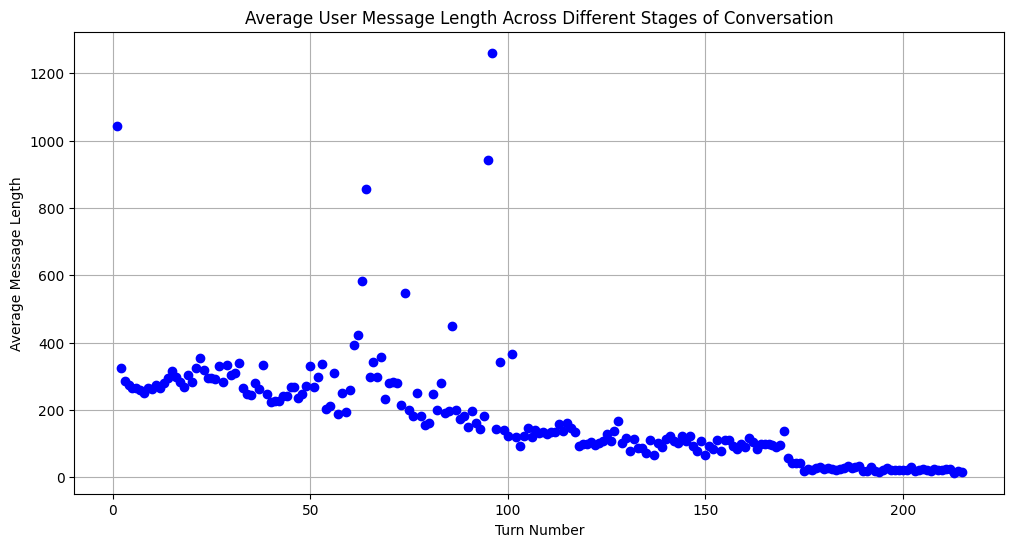

In [13]:
from pyspark.sql.functions import col, explode, size, length
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window



# Explode the conversation array to have one row per message
exploded_df = combined_df.withColumn("message", explode("conversation"))
#exploded_df.show(5)


#exploded_df.select("message").show(1, truncate=False)
#exploded_df.select("conversation").show(1, truncate=False)

# Filter messages where role is "user"
user_messages_df = exploded_df.filter(col("message.role") == "user")
#user_messages_df.show(5)

# Add a column with the content of the message
user_messages_df = user_messages_df.withColumn("content", col("message.content")) 
 
# Add a column with the turn number for each message within a conversation
window_spec = Window.partitionBy("conversation_identifier").orderBy("timestamp")
user_messages_df = user_messages_df.withColumn("turn_number", row_number().over(window_spec))



# Calculate the length of each content
user_messages_df = user_messages_df.withColumn("content_length", length(col("content")))
# Calculate the average content length per turn
avg_content_length_per_turn_df = user_messages_df.groupBy("turn_number").agg({"content_length": "avg"}).withColumnRenamed("avg(content_length)", "avg_content_length")

# Show the results
avg_content_length_per_turn_df.show(10)
# Filter to keep only turns up to the value 215
filtered_avg_message_length_df = avg_content_length_per_turn_df.filter(col("turn_number") <= 215)

# Store the result in another DataFrame
avg_message_length_df = filtered_avg_message_length_df

# Convert to Pandas DataFrame for visualization
avg_message_length_pd_df = avg_message_length_df.select("turn_number", "avg_content_length").toPandas()

# Plot the average message length across different stages of conversation.
plt.figure(figsize=(12, 6))
plt.plot(avg_message_length_pd_df["turn_number"], avg_message_length_pd_df["avg_content_length"], marker='o', linestyle='', color='b')
plt.title("Average User Message Length Across Different Stages of Conversation")
plt.xlabel("Turn Number")
plt.ylabel("Average Message Length")
plt.grid(True)
plt.show()



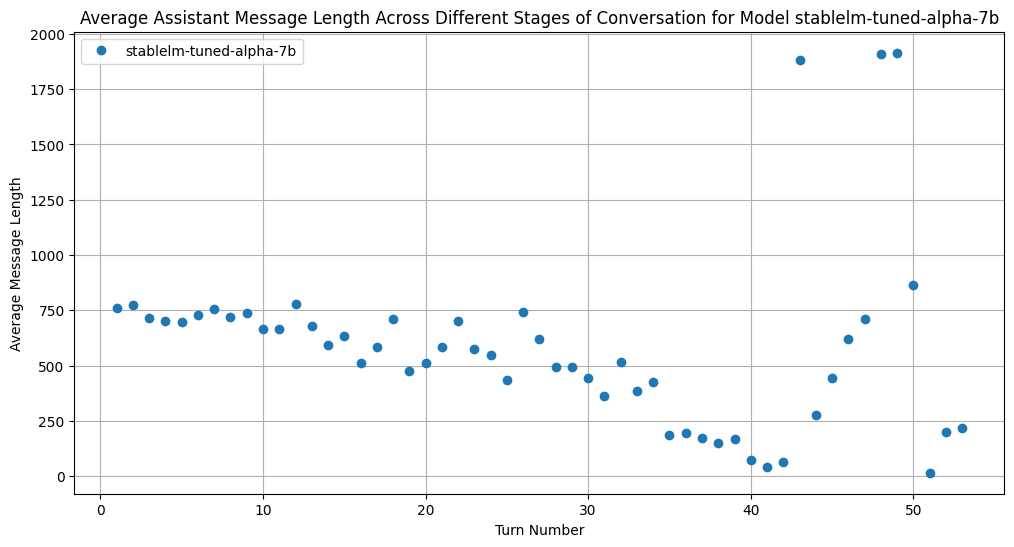

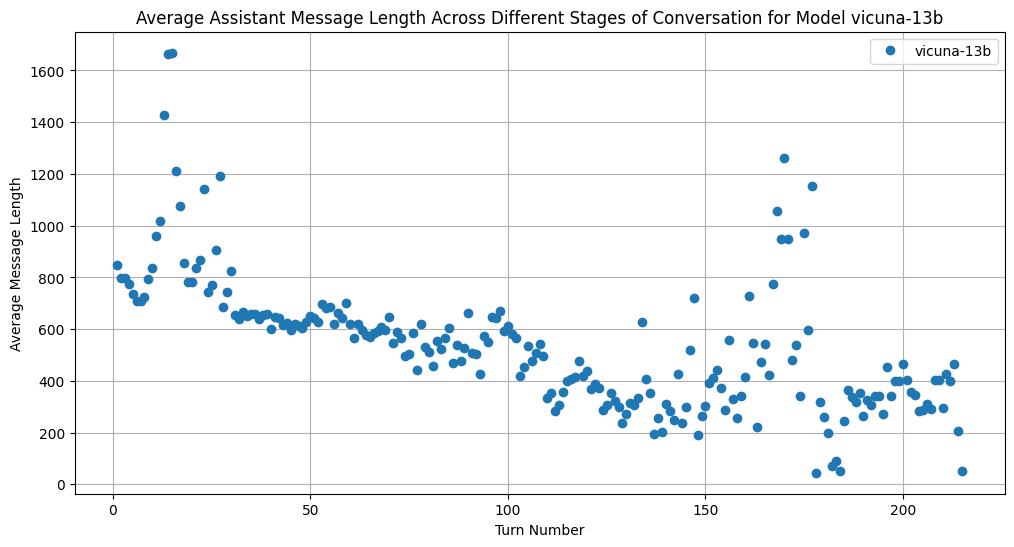

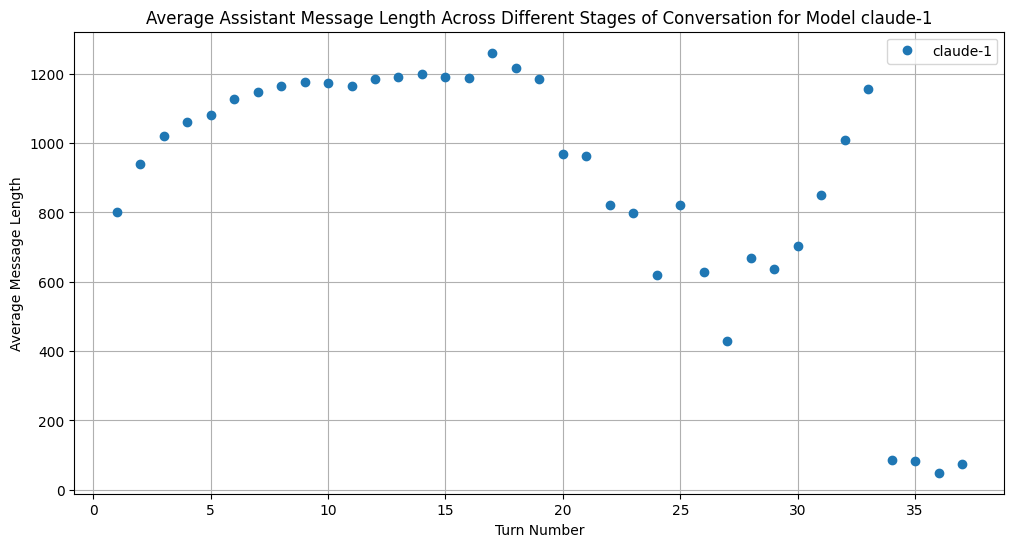

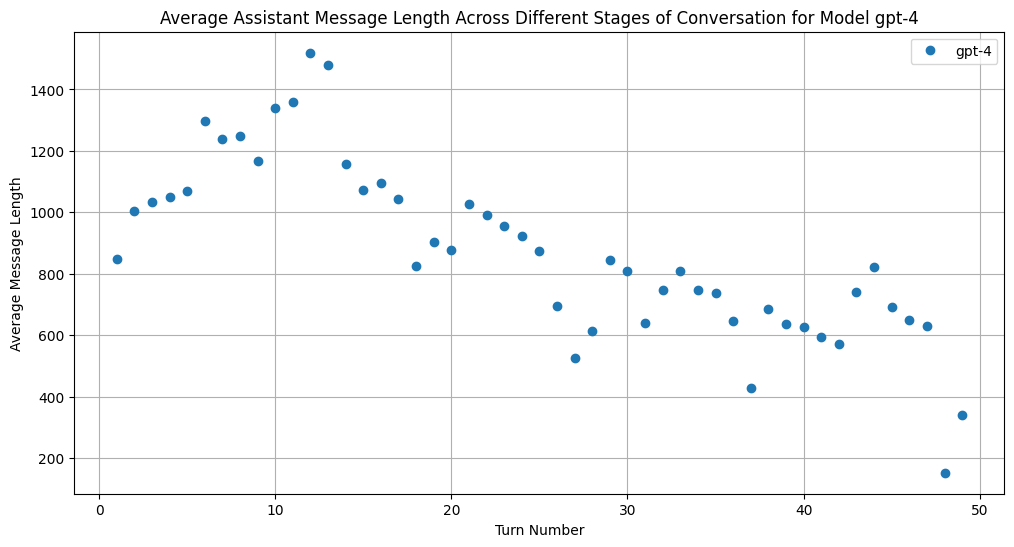

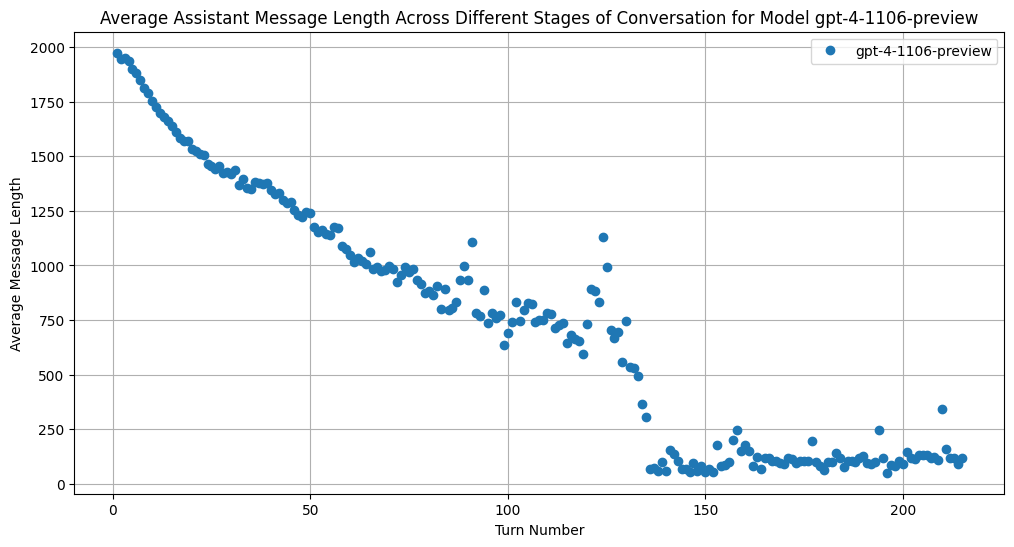

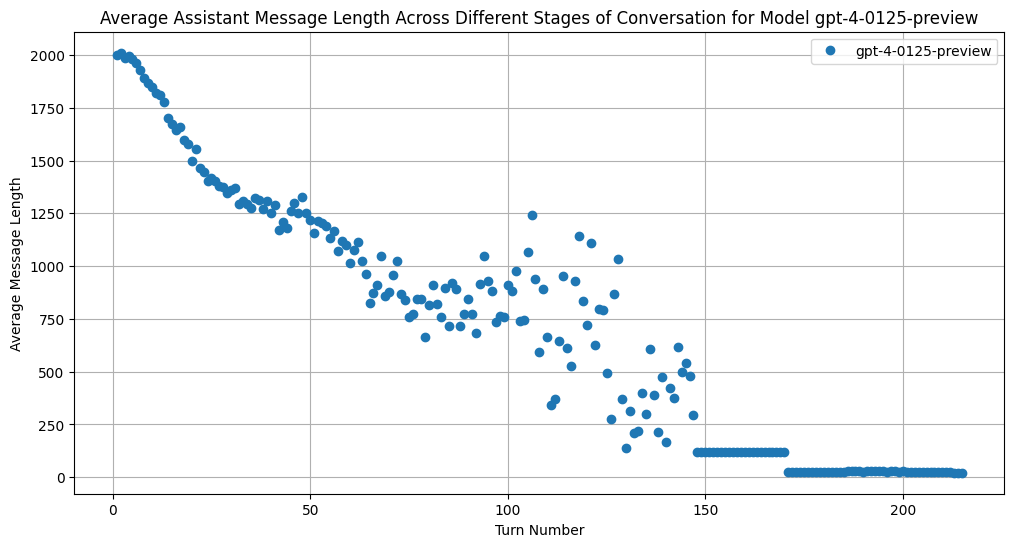

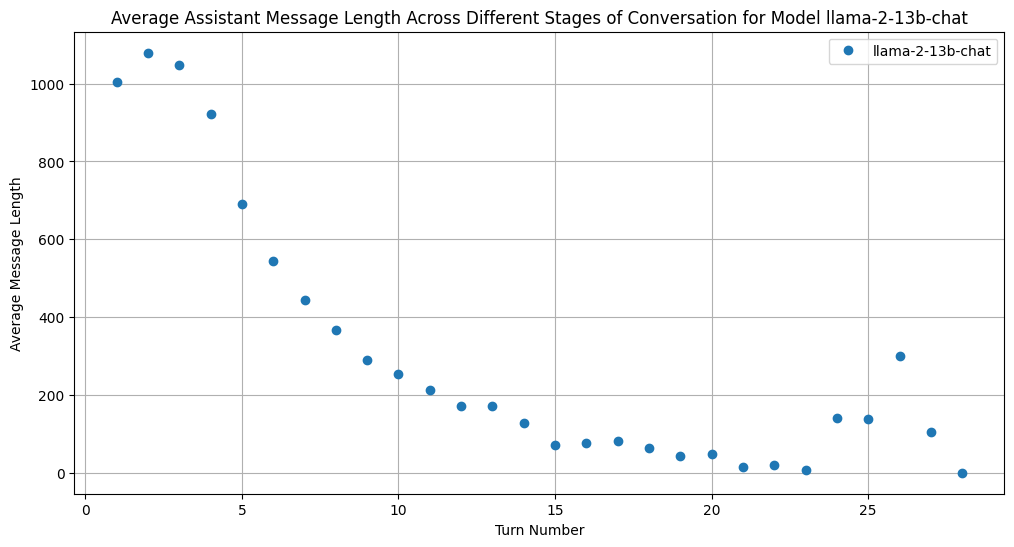

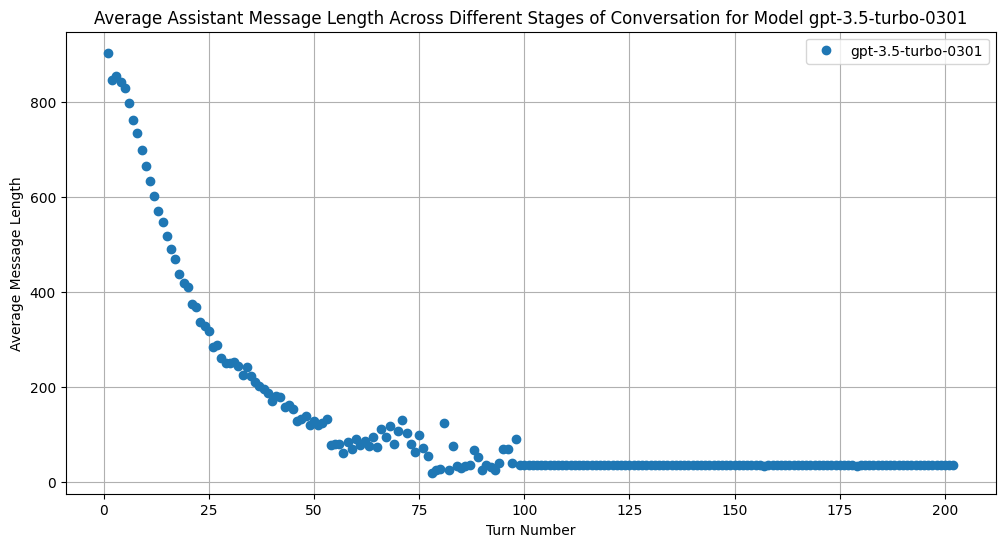

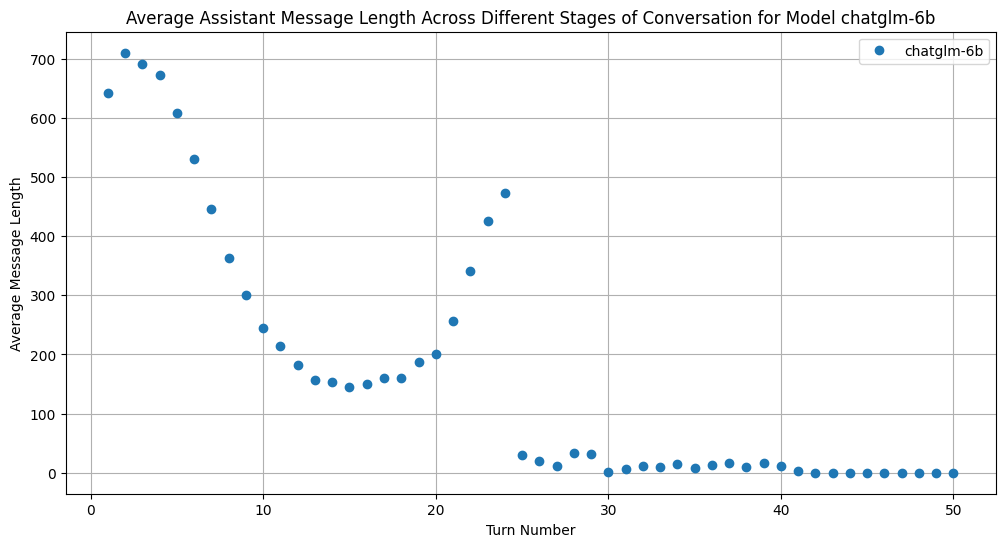

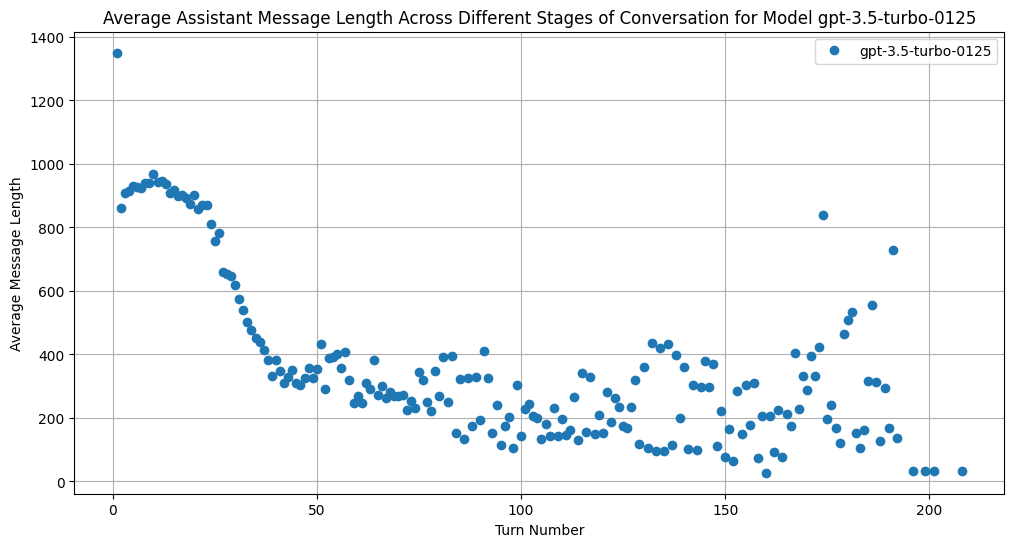

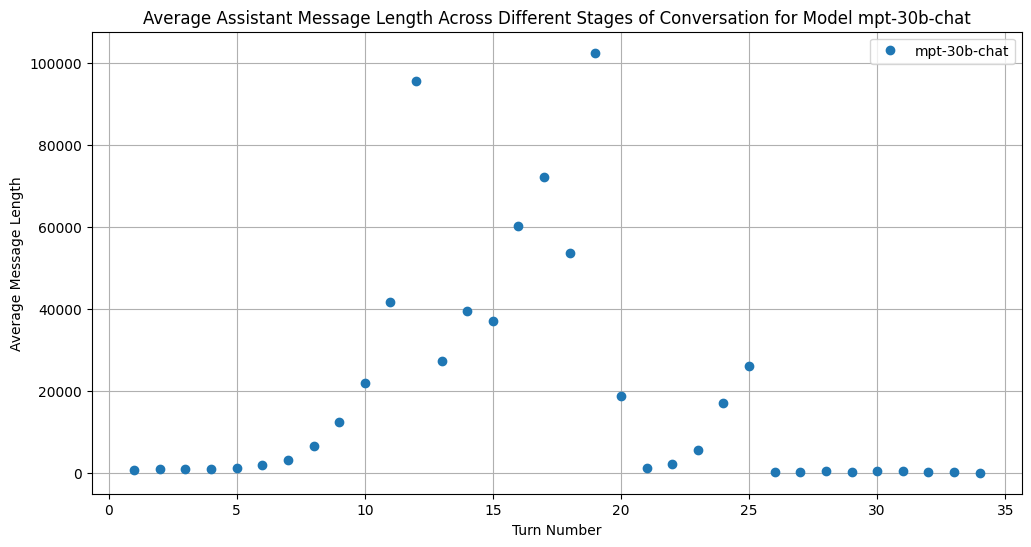

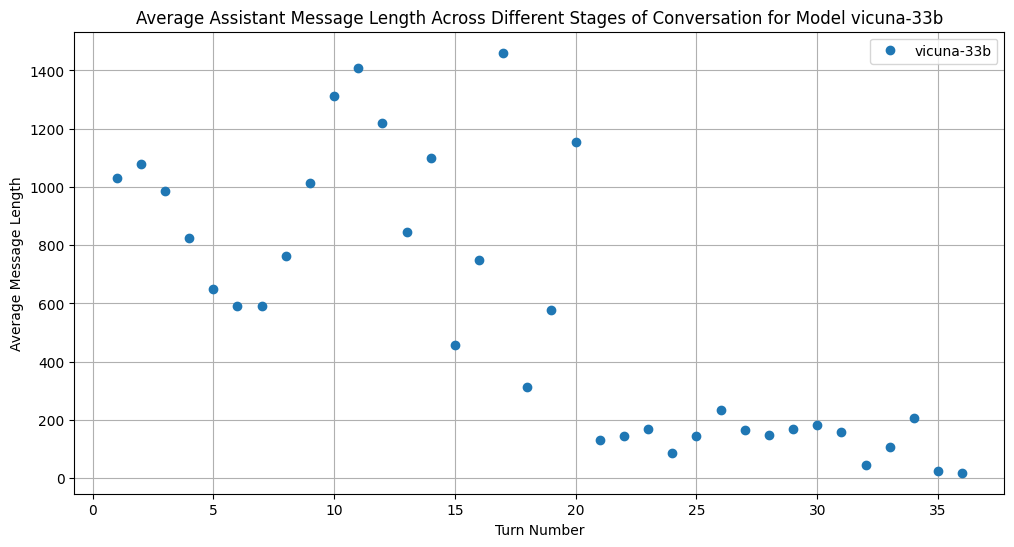

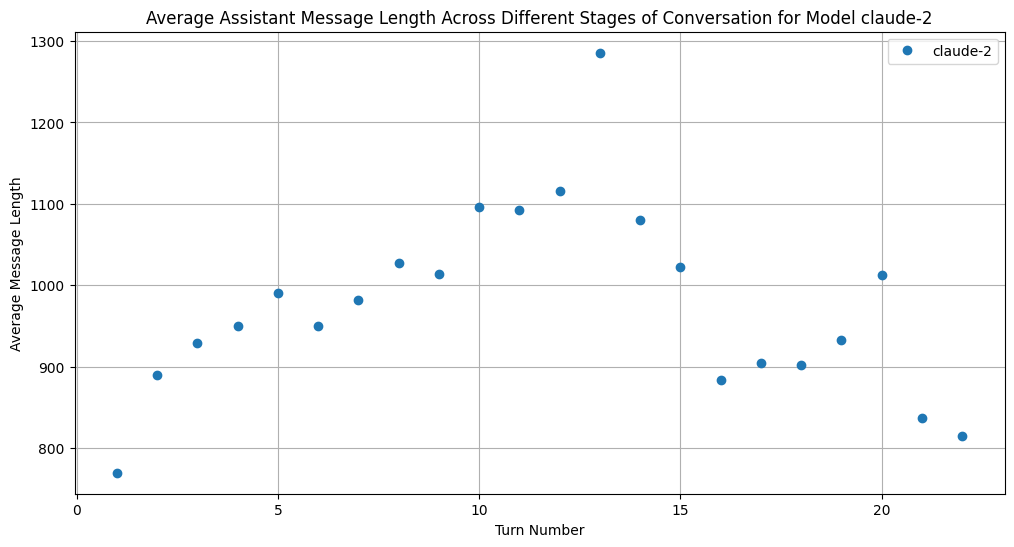

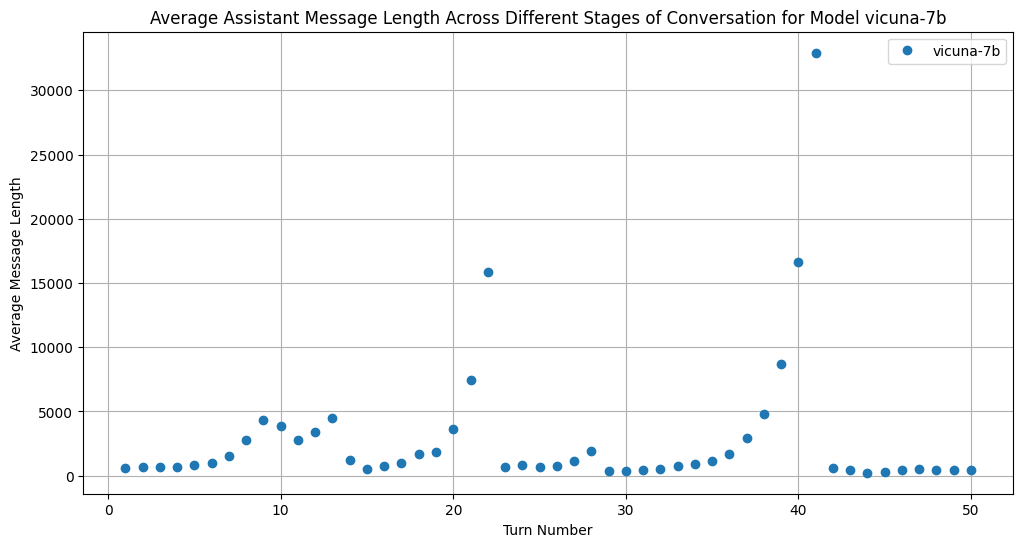

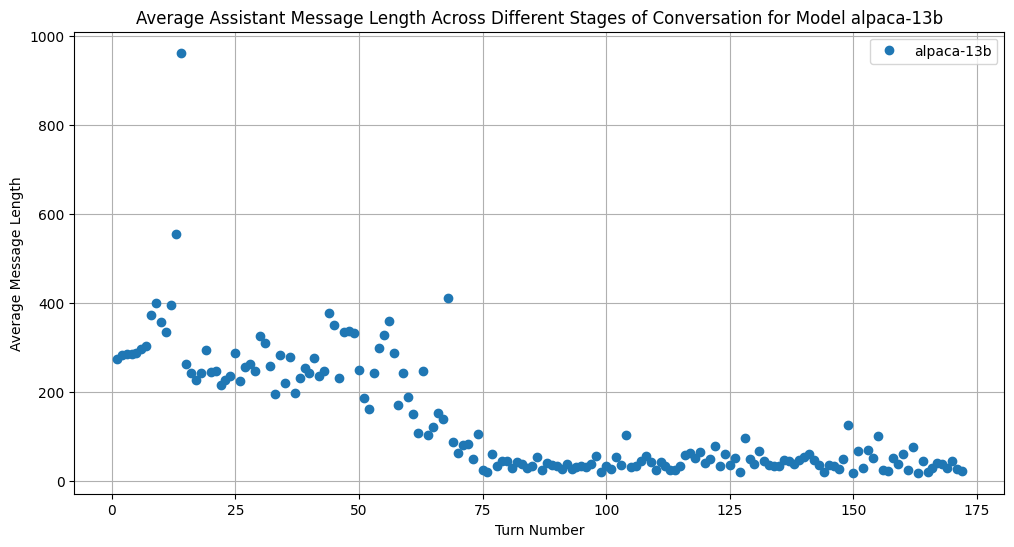

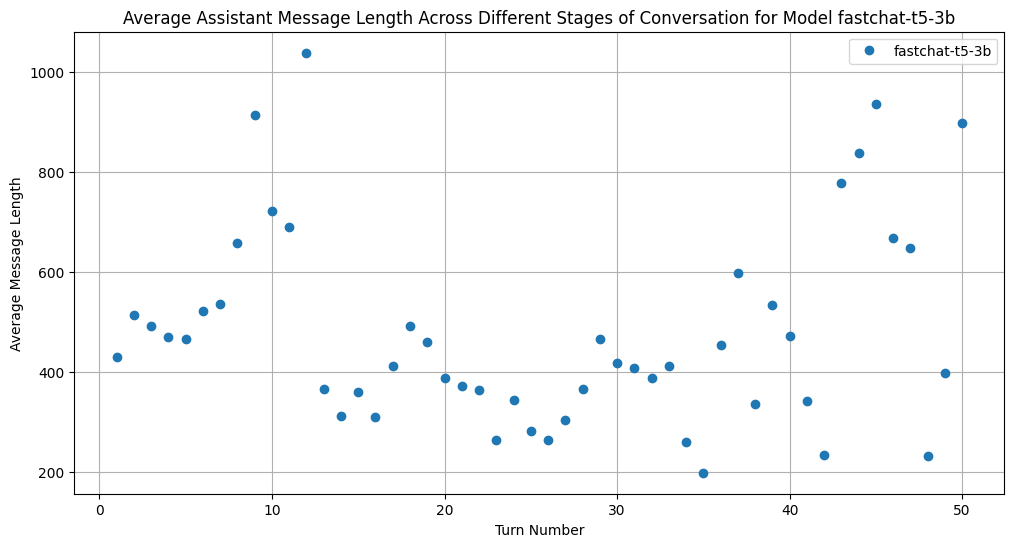

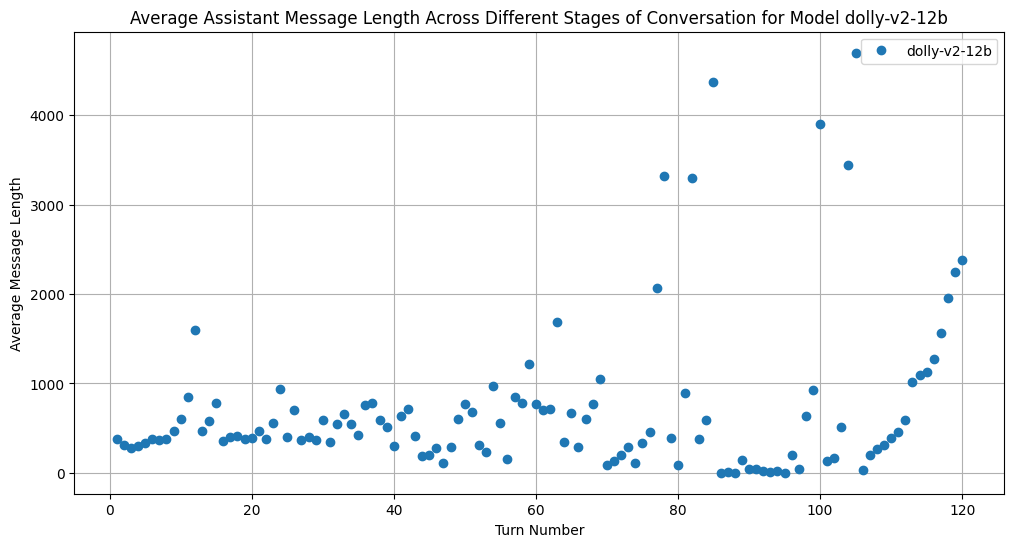

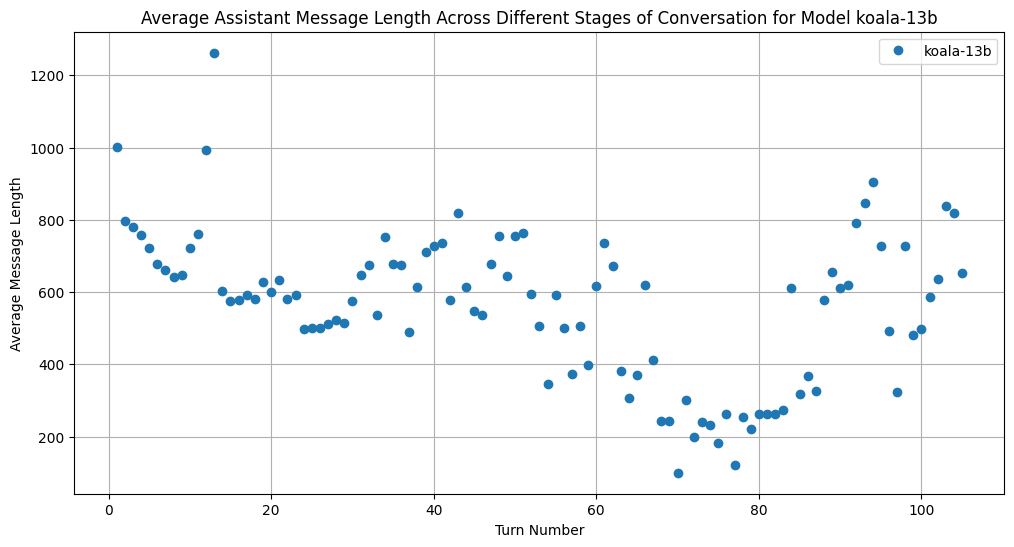

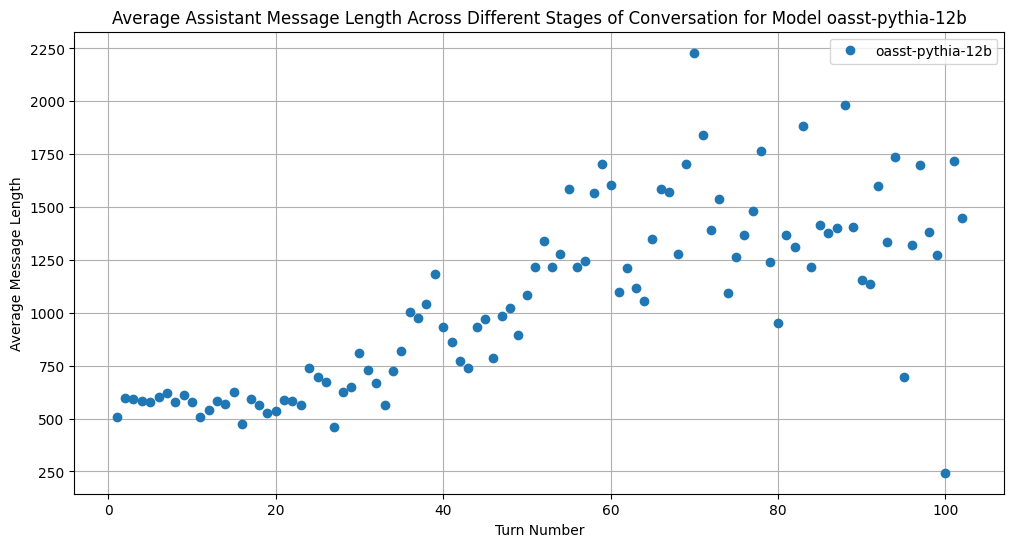

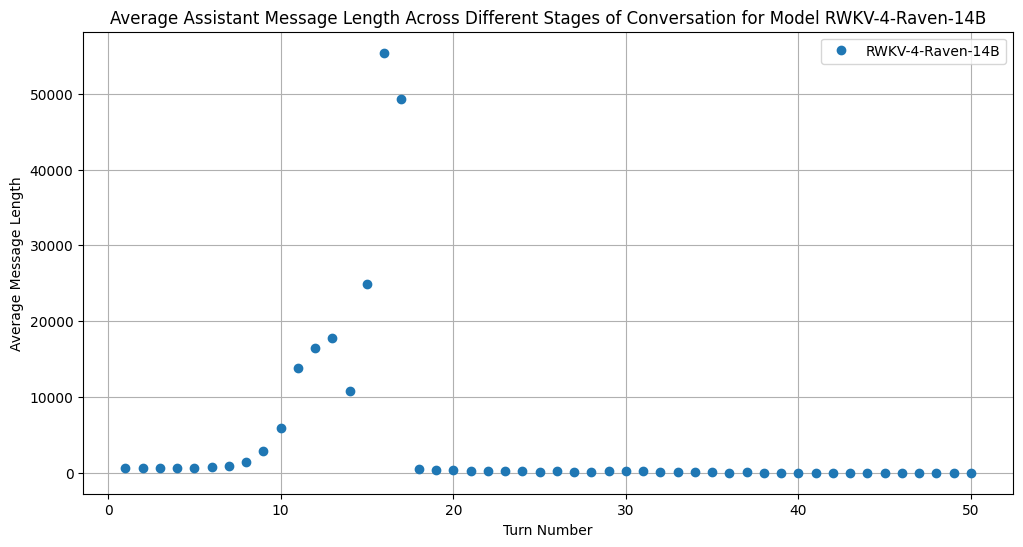

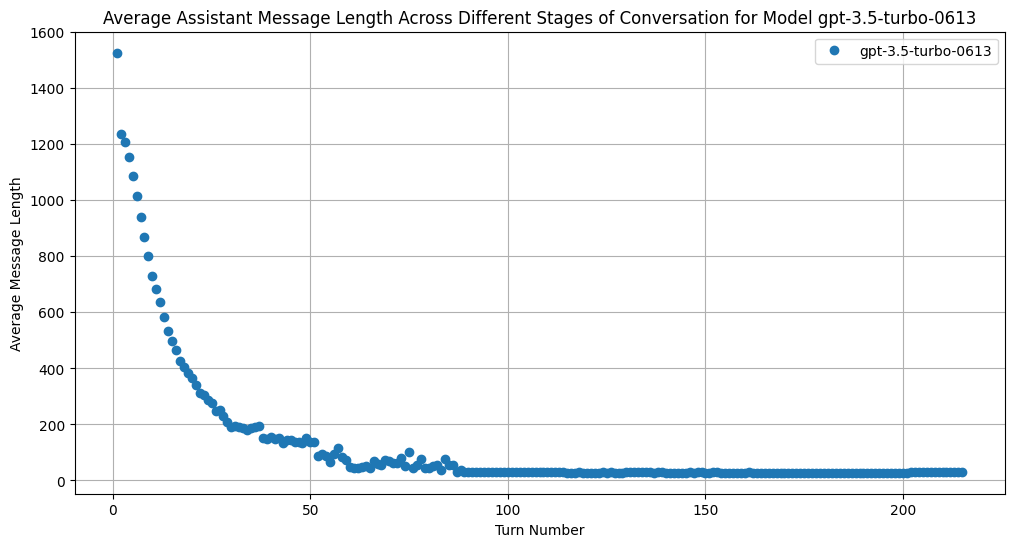

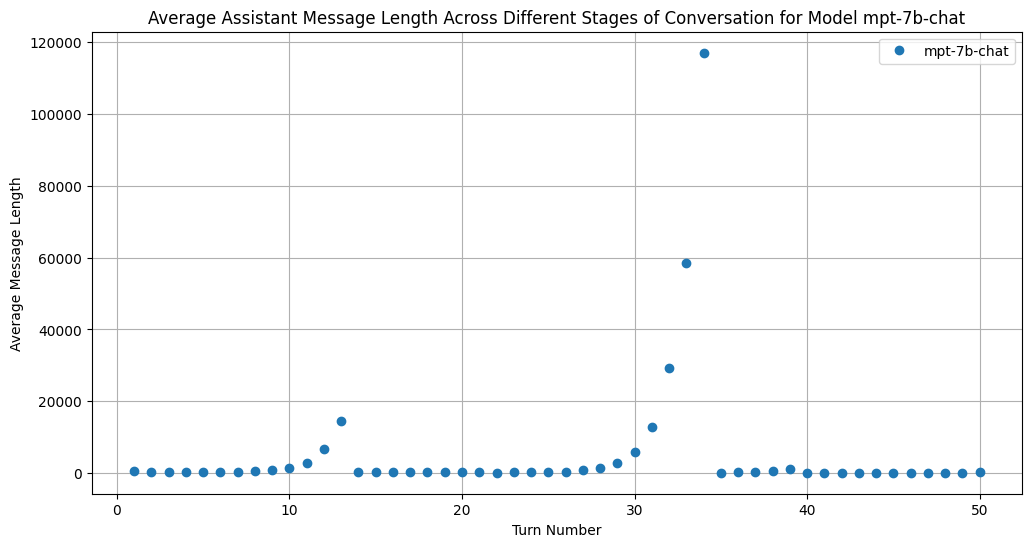

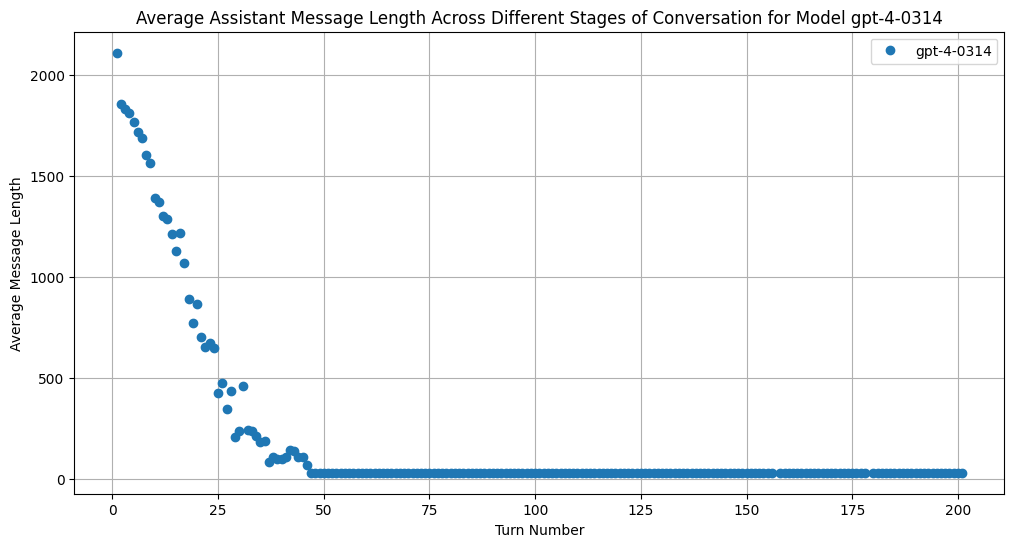

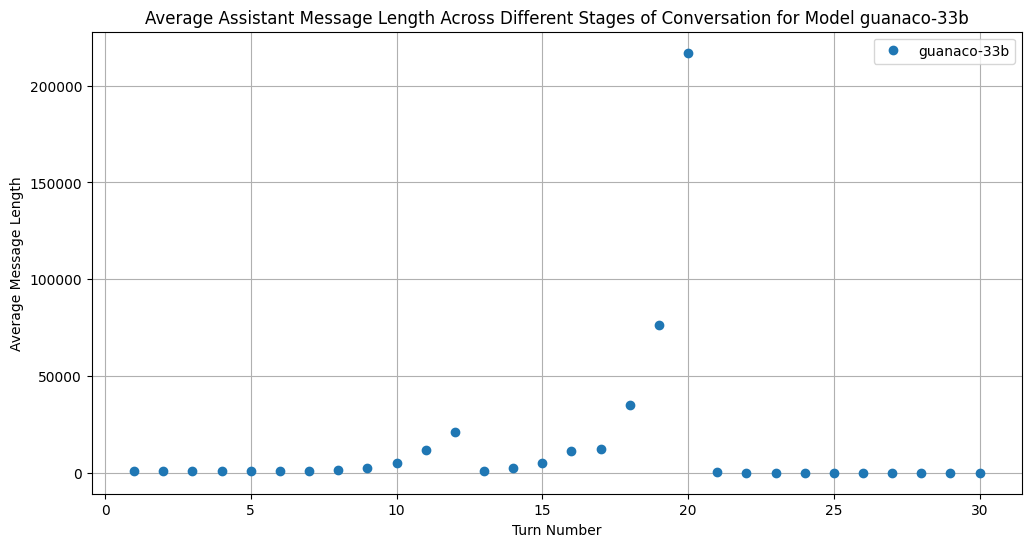

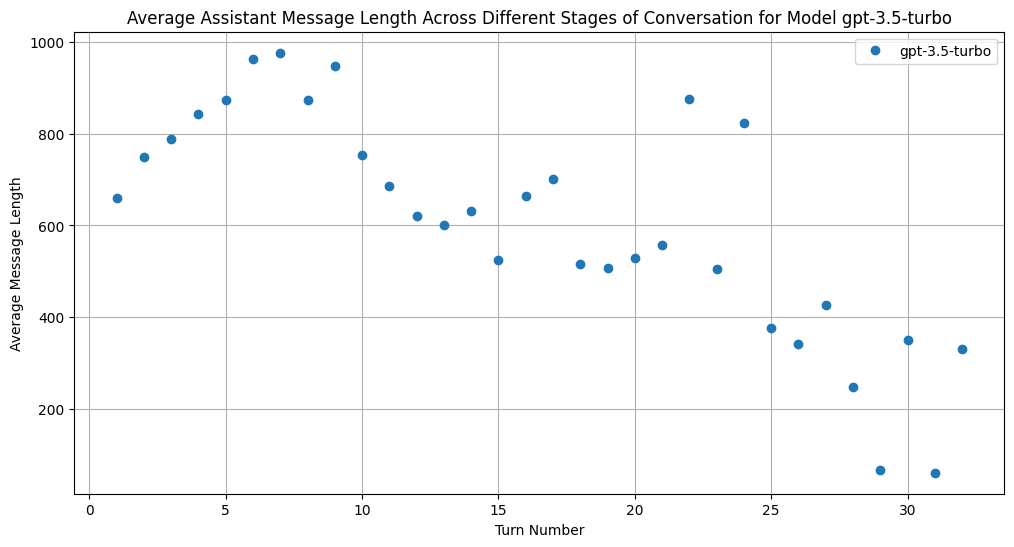

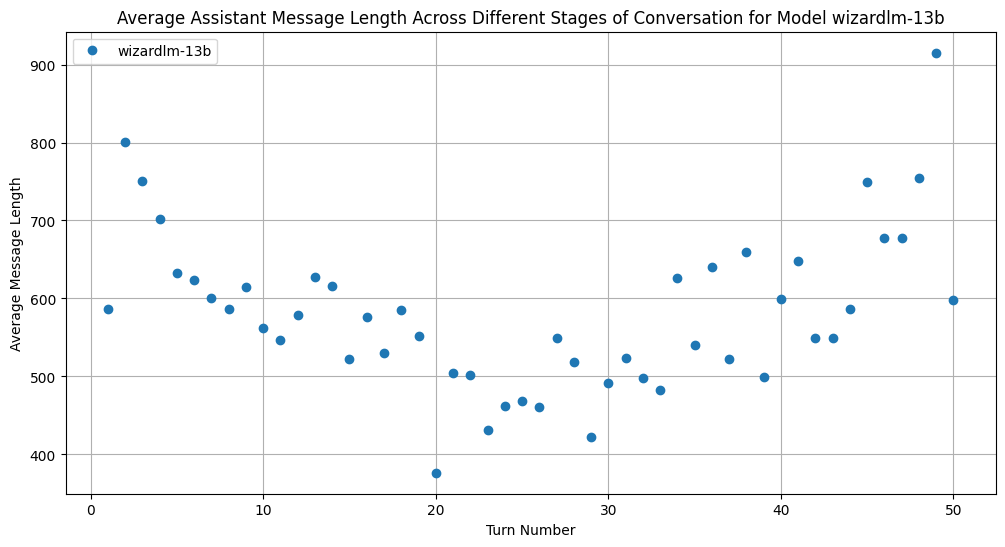

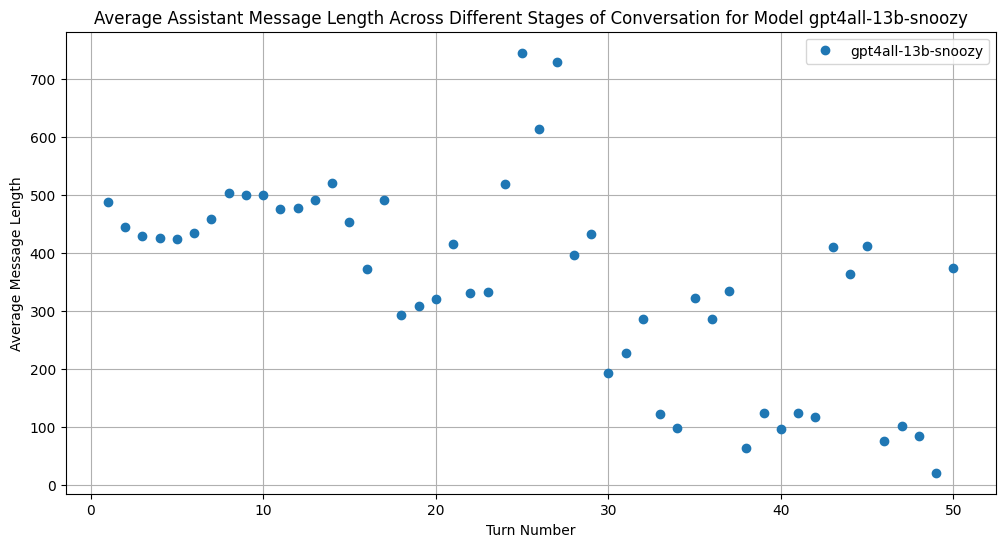

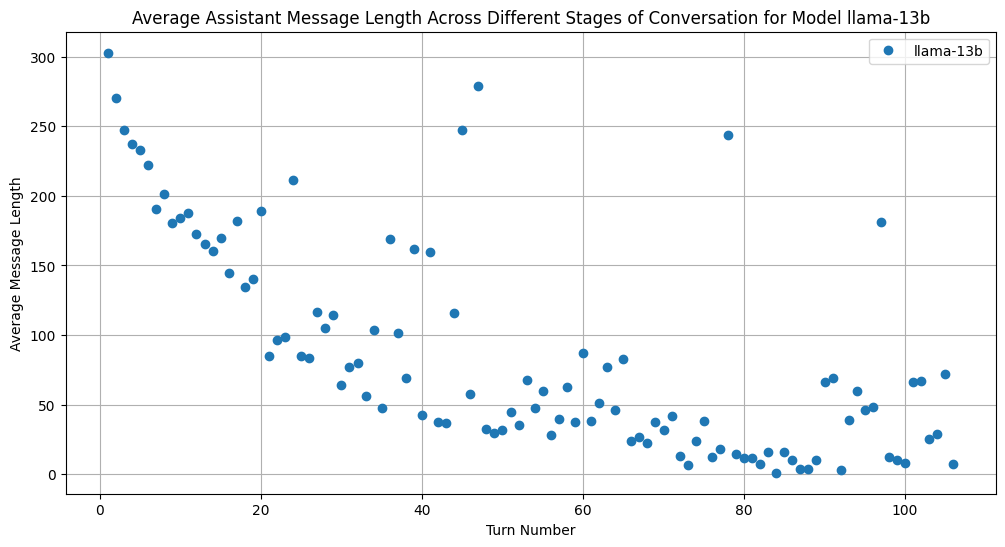

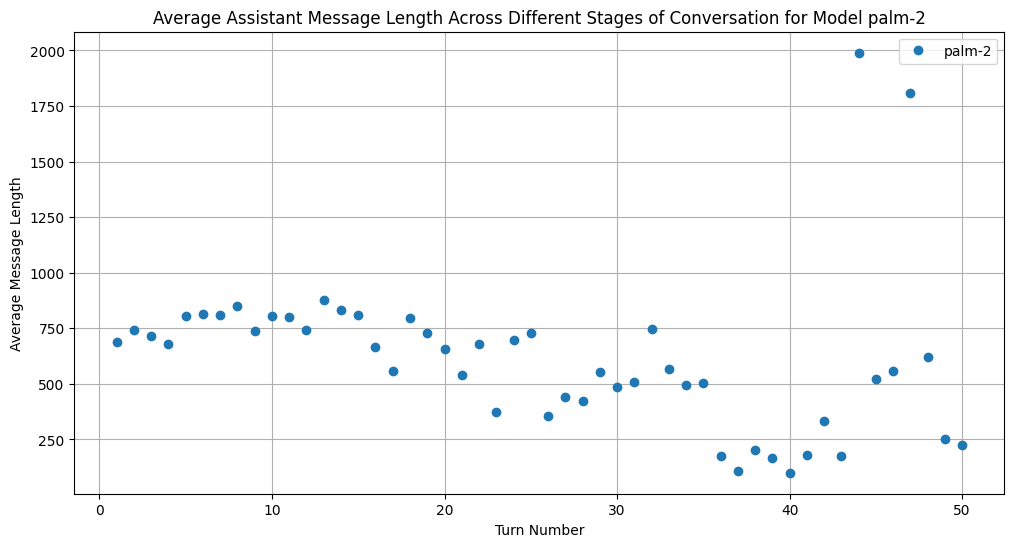

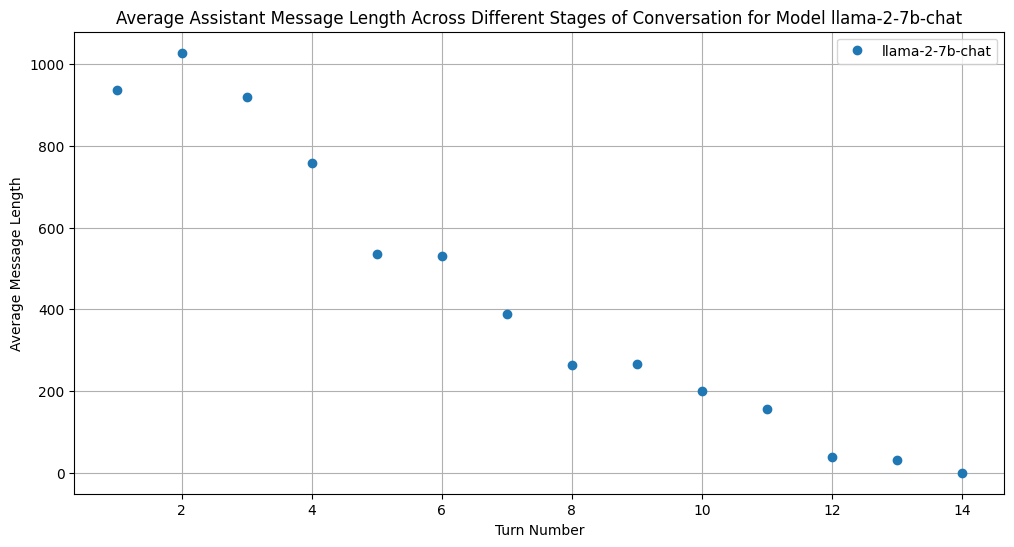

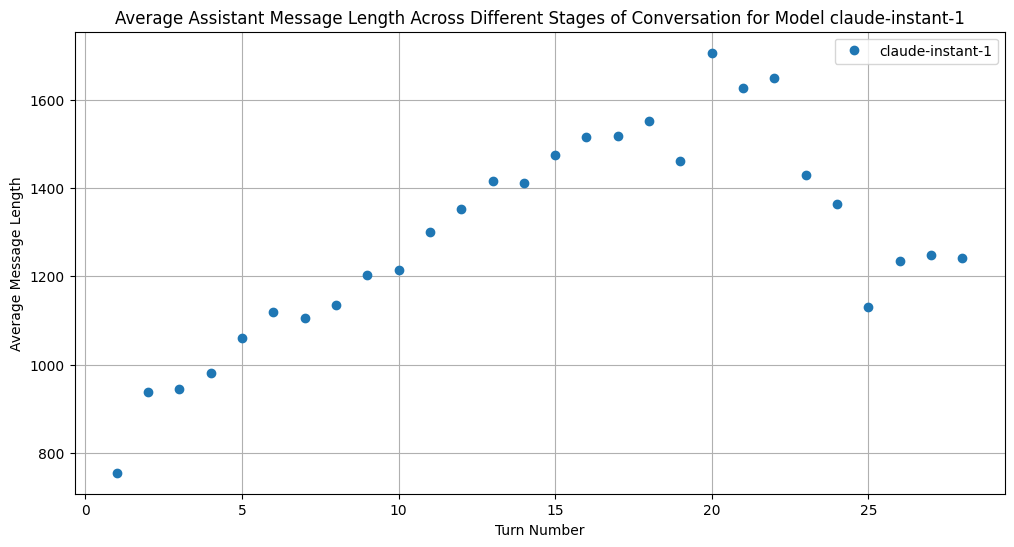

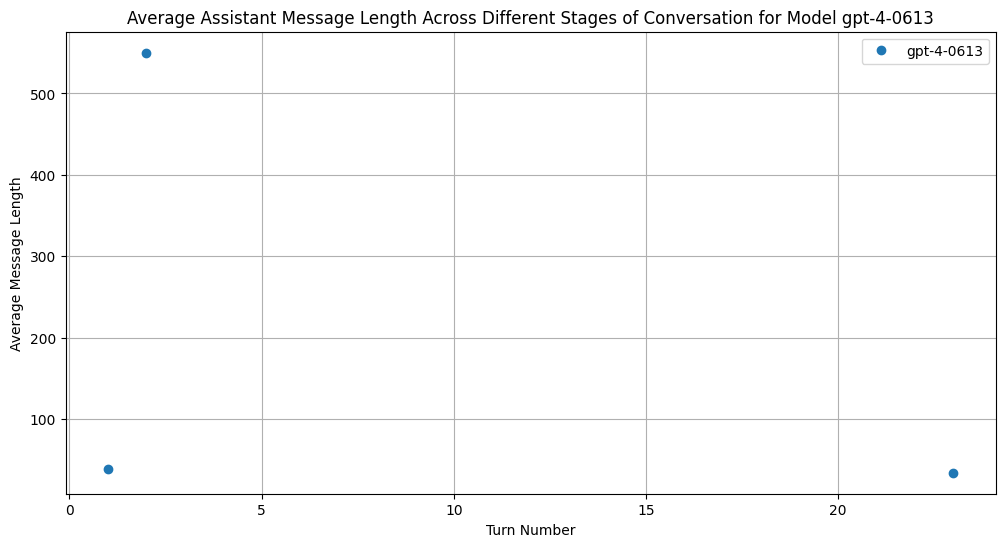

In [14]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
# Filter messages where role is "assistant"
assistant_messages_df = exploded_df.filter(col("message.role") == "assistant")

# Add a column with the content of the message
assistant_messages_df = assistant_messages_df.withColumn("content", col("message.content"))

# Add a column with the turn number for each message within a conversation
assistant_messages_df = assistant_messages_df.withColumn("turn_number", row_number().over(window_spec))

# Calculate the length of each content
assistant_messages_df = assistant_messages_df.withColumn("content_length", length(col("content")))

# Calculate the average content length per turn and model
avg_content_length_per_turn_model_df = assistant_messages_df.groupBy("turn_number", "model").agg({"content_length": "avg"}).withColumnRenamed("avg(content_length)", "avg_content_length")


# Filter to keep only turns up to the value 215
filtered_avg_content_length_per_turn_model_df = avg_content_length_per_turn_model_df.filter(col("turn_number") <= 215)

# Convert to Pandas DataFrame for visualization
filtered_avg_content_length_per_turn_model_pd_df = filtered_avg_content_length_per_turn_model_df.select("turn_number", "model", "avg_content_length").toPandas()

# Plot the average message length across different stages of conversation for each model
models = filtered_avg_content_length_per_turn_model_pd_df["model"].unique()
for model in models:
    model_df = filtered_avg_content_length_per_turn_model_pd_df[filtered_avg_content_length_per_turn_model_pd_df["model"] == model]
    
    plt.figure(figsize=(12, 6))
    plt.plot(model_df["turn_number"], model_df["avg_content_length"], marker='o', linestyle='', label=model)
    plt.title(f"Average Assistant Message Length Across Different Stages of Conversation for Model {model}")
    plt.xlabel("Turn Number")
    plt.ylabel("Average Message Length")
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
# Calculate the number of different models
num_models = len(models)

# Print the number of different models
print(f"Number of different models: {num_models}")

Number of different models: 32


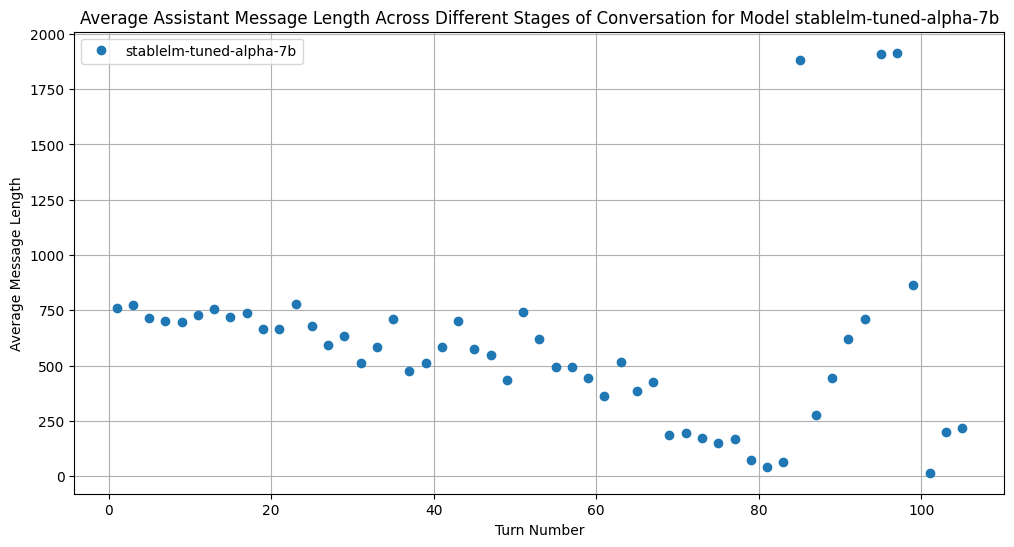

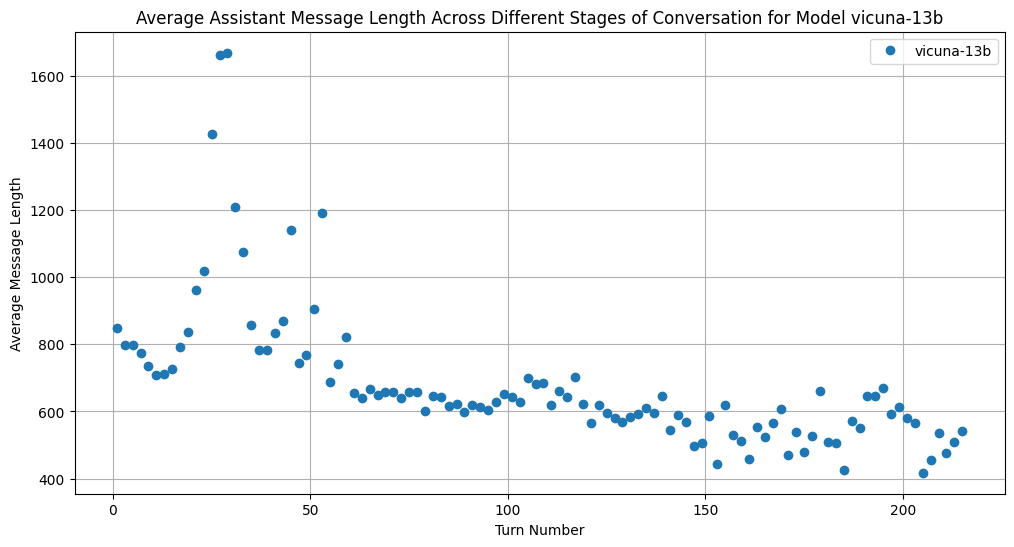

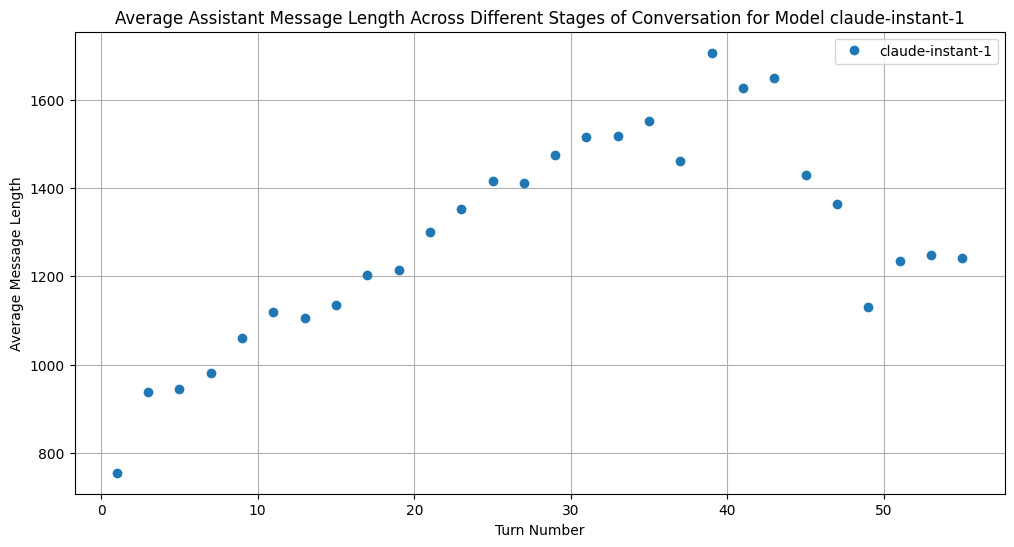

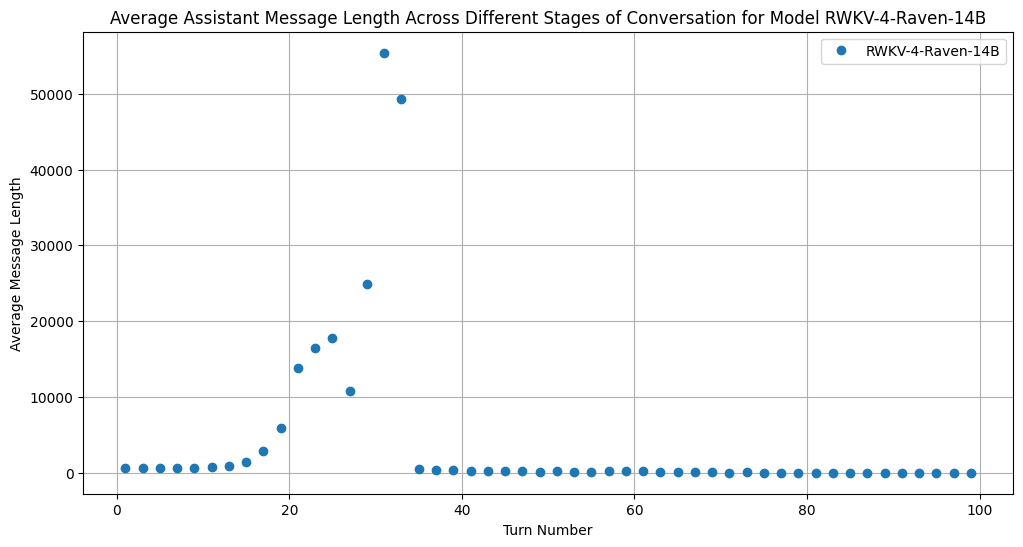

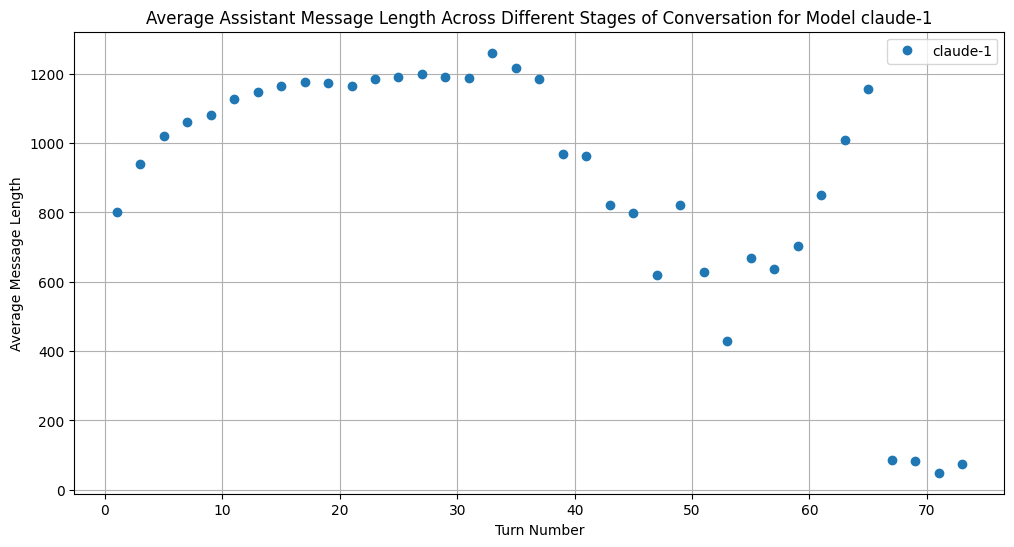

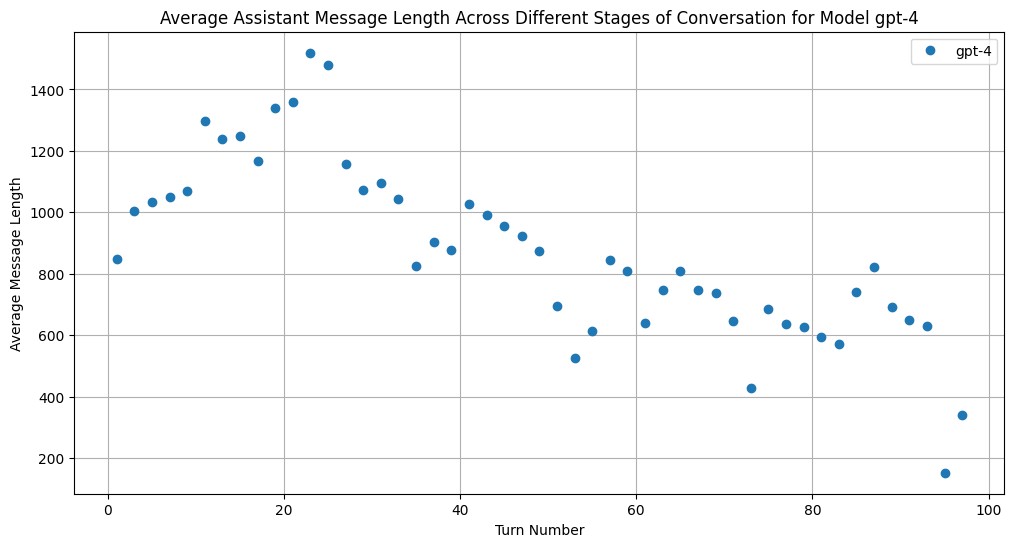

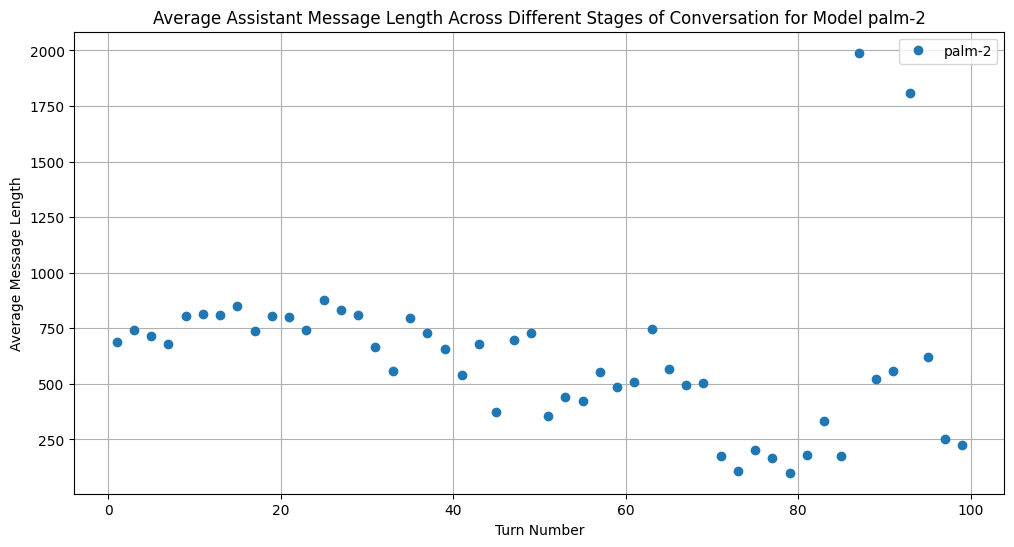

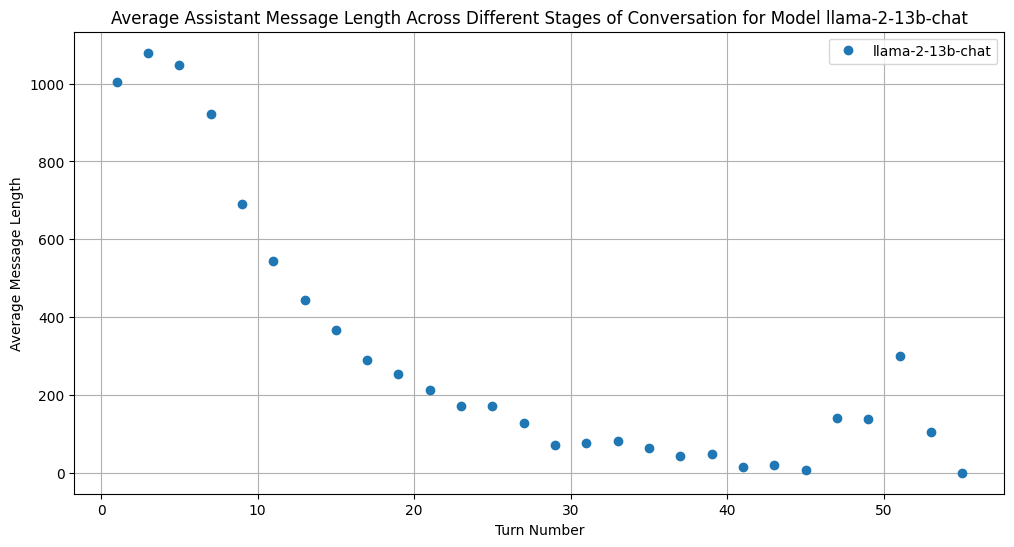

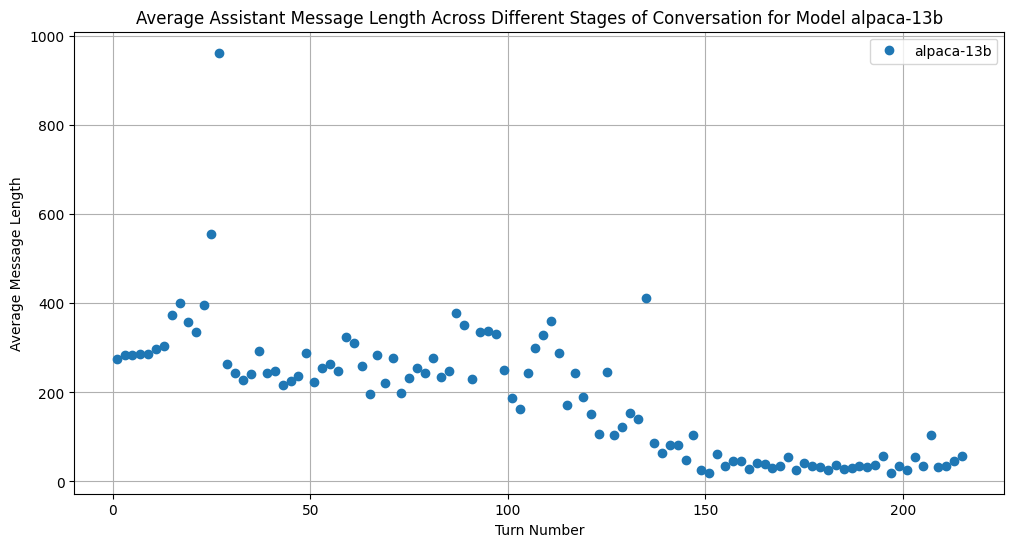

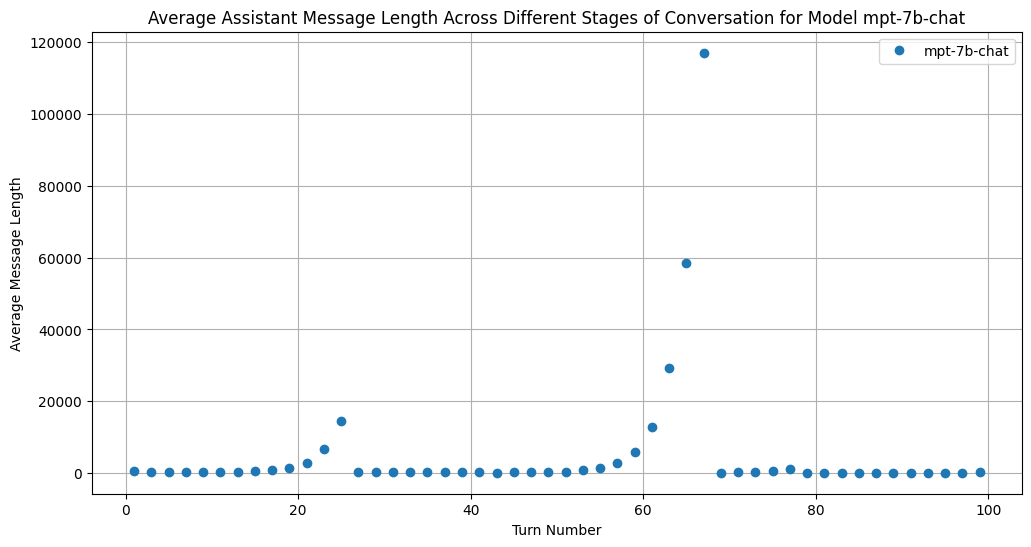

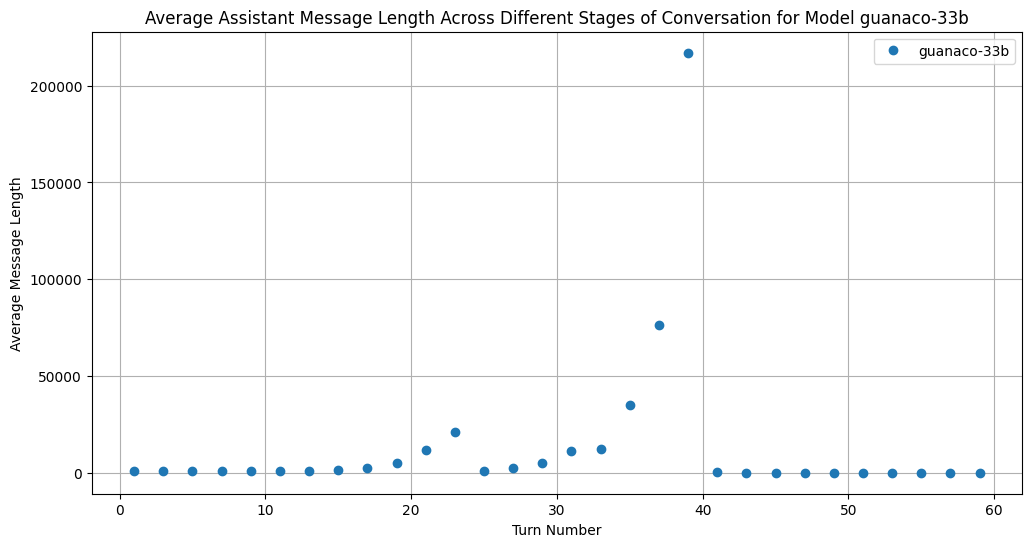

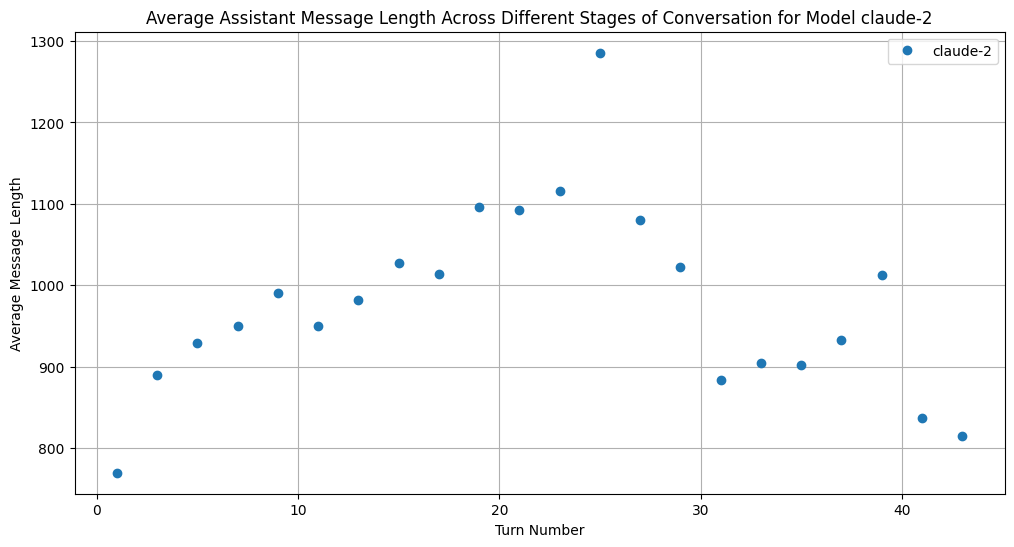

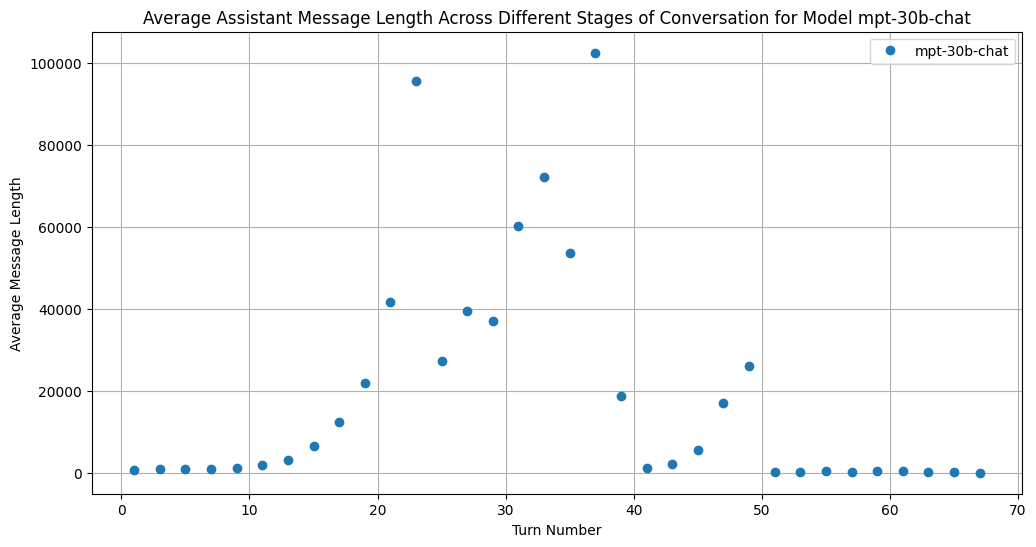

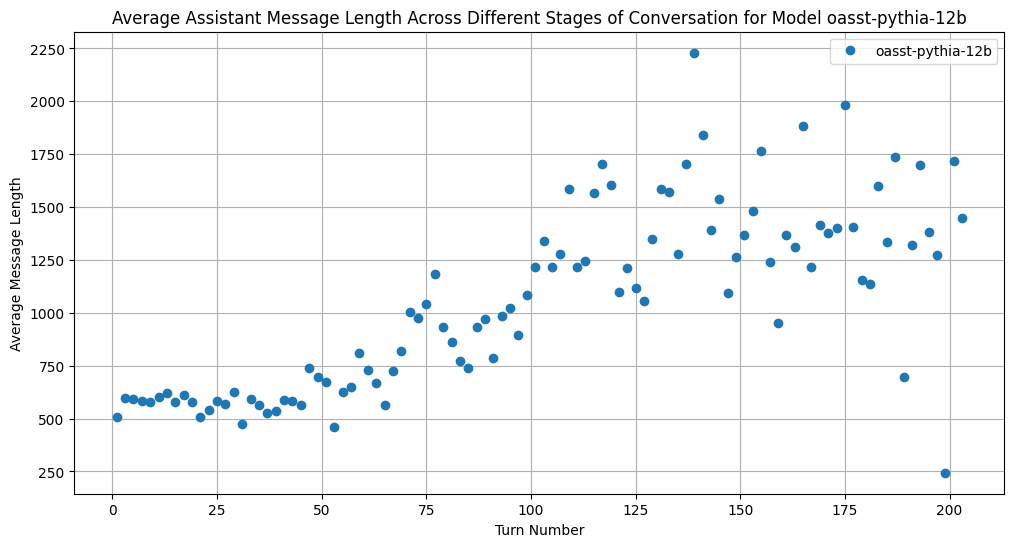

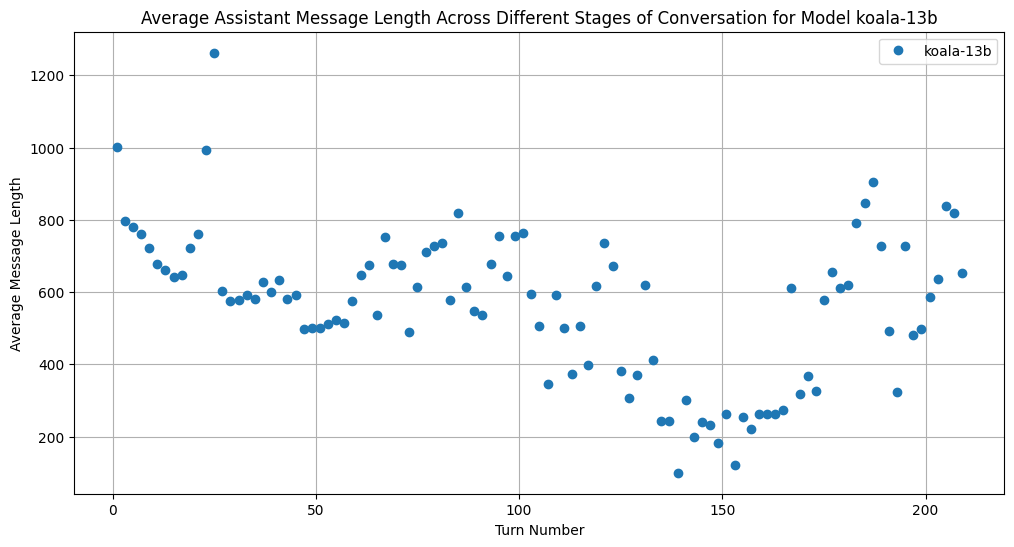

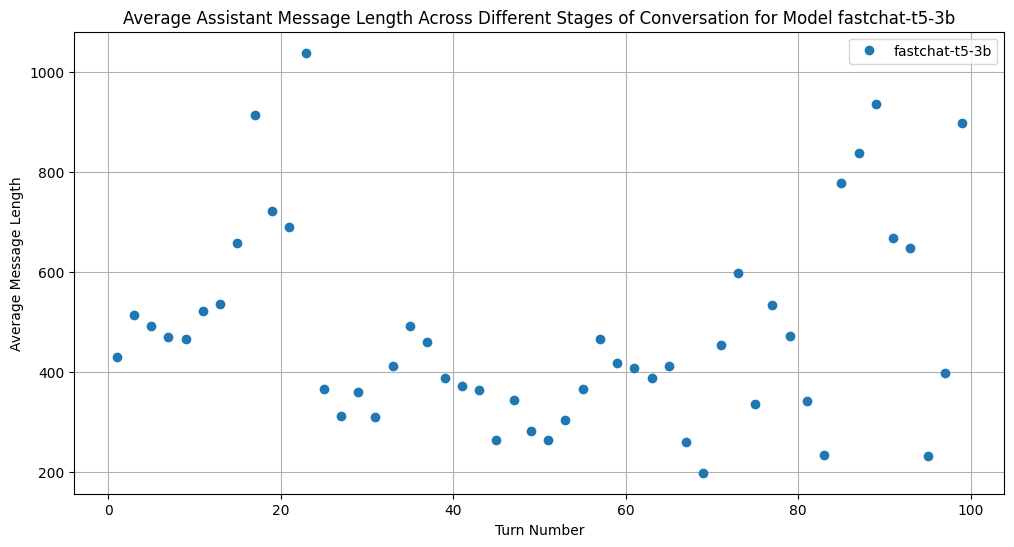

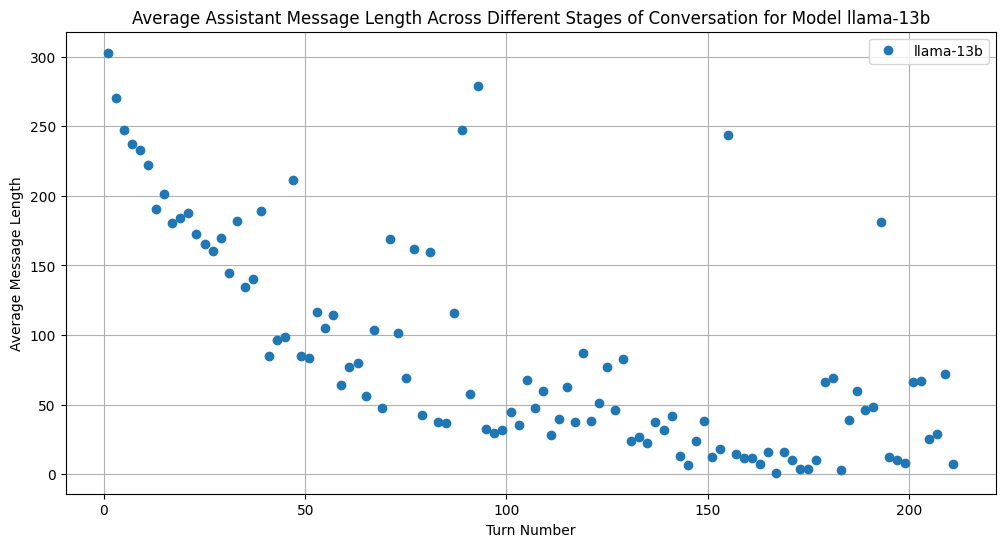

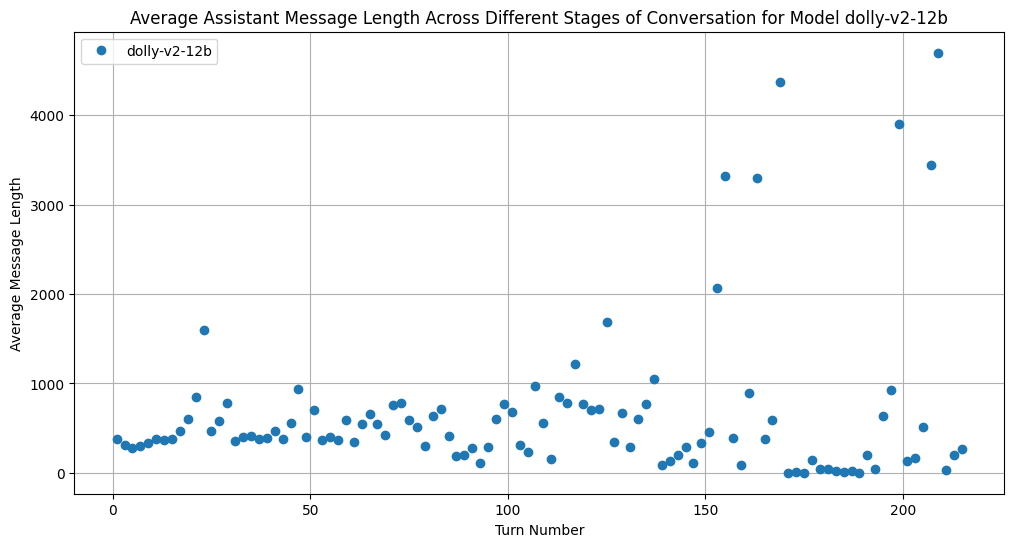

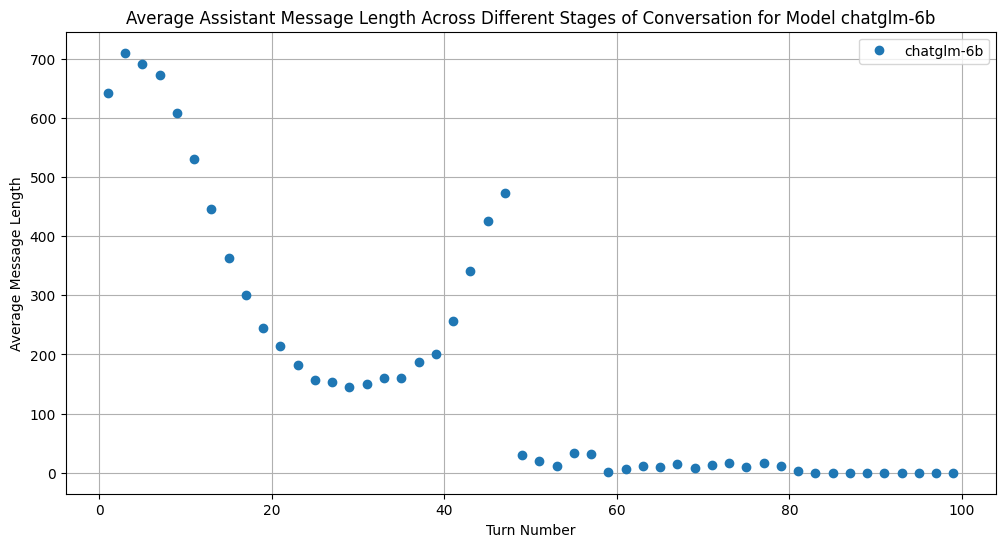

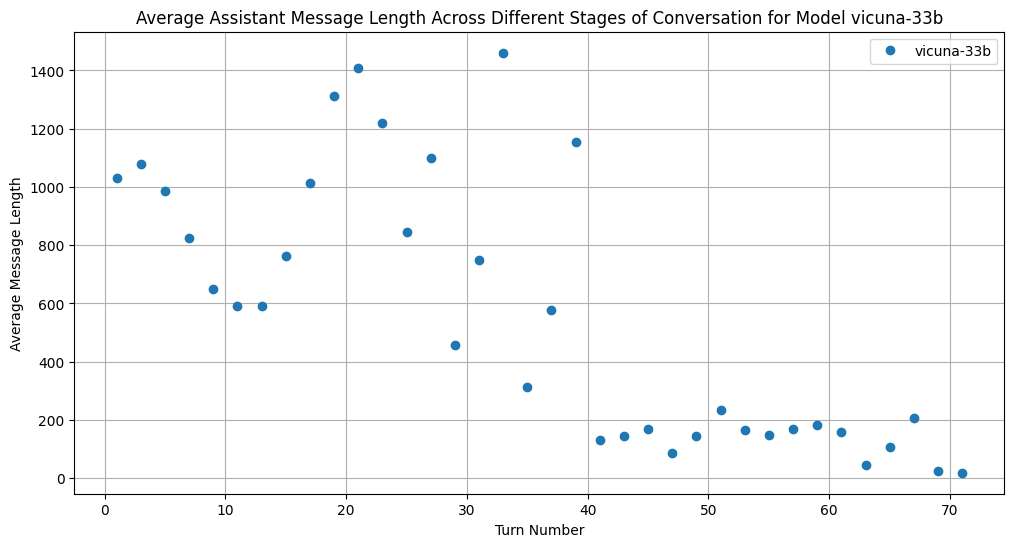

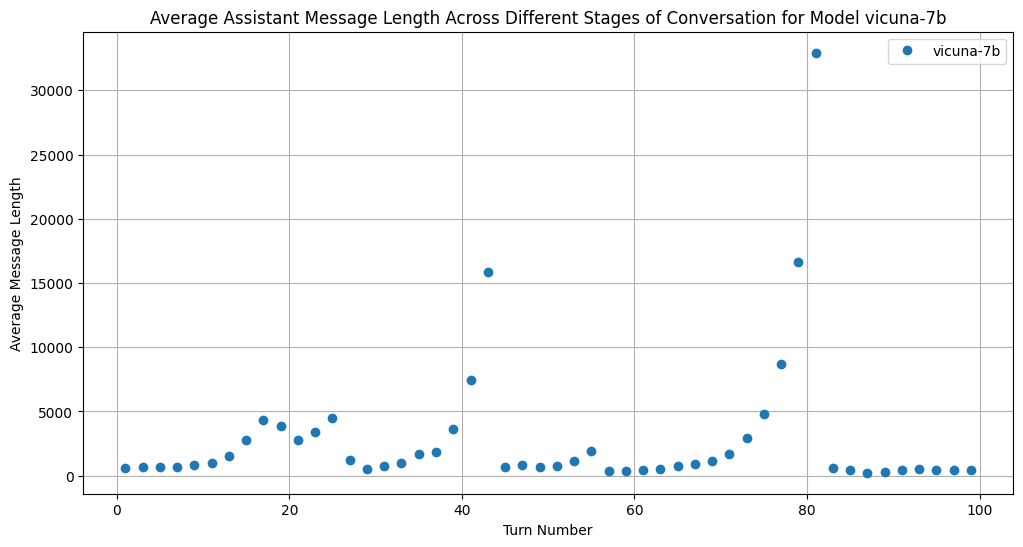

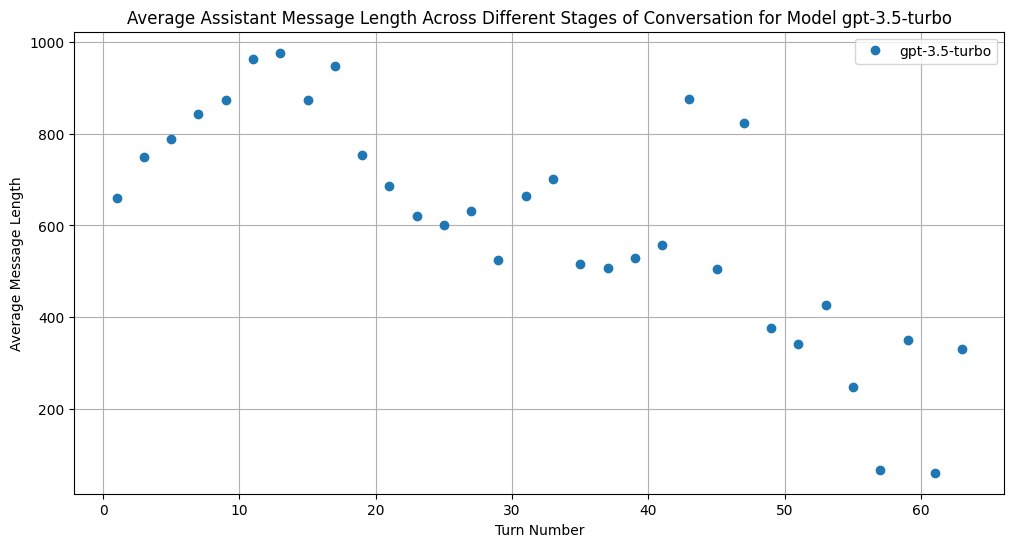

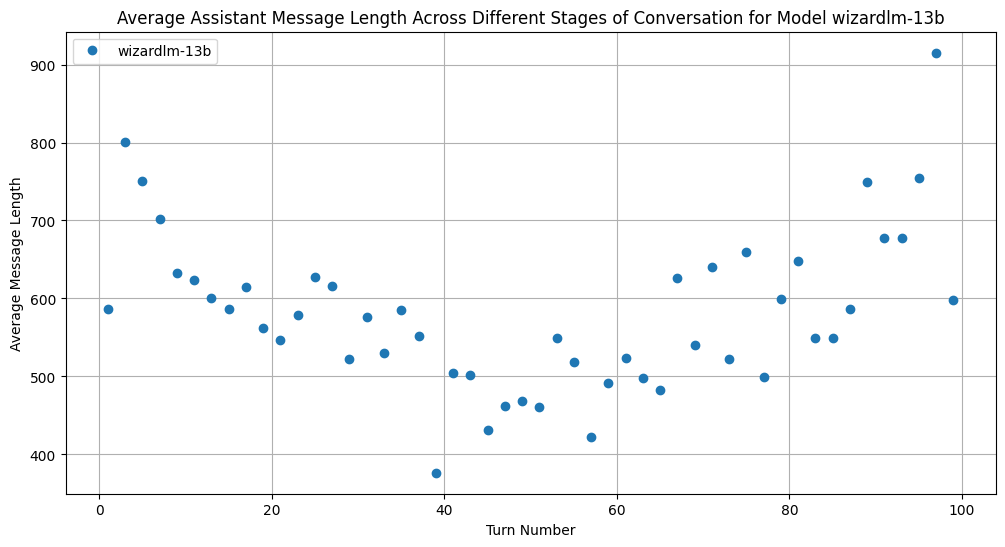

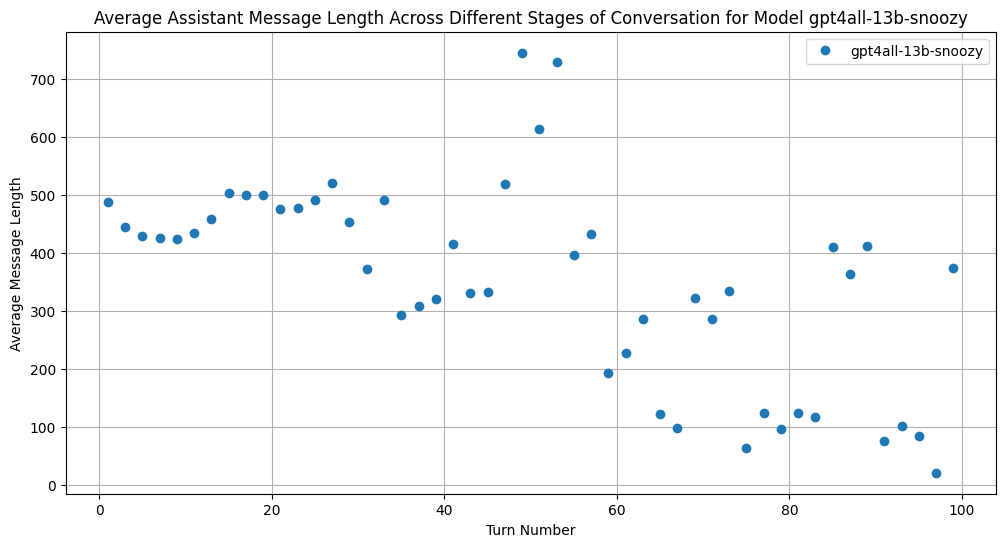

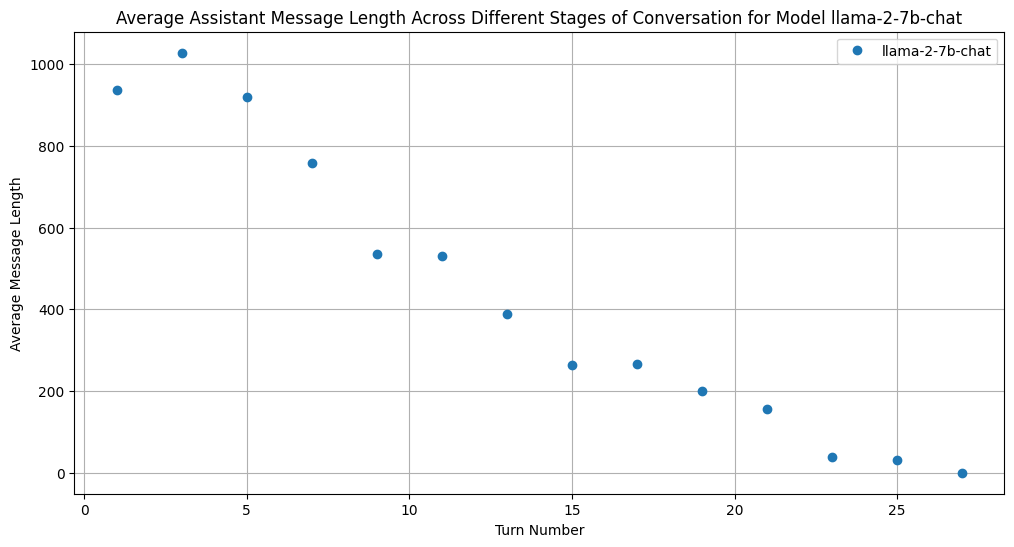

In [23]:
from pyspark.sql.functions import col, length, posexplode

import matplotlib.pyplot as plt

# Extract the content field from the message column and calculate its length
assistant_messages_lmsys_df = lmsys_df \
    .select("model", posexplode("conversation").alias("turn_number", "message")) \
    .filter(col("message.role") == "assistant") \
    .withColumn("content", col("message.content")) \
    .withColumn("content_length", length(col("content")))

# Group by turn_number and model to get the average content length per turn
avg_content_length_per_turn_lmsys_df = assistant_messages_lmsys_df \
    .groupBy("turn_number", "model") \
    .agg({"content_length": "avg"}) \
    .withColumnRenamed("avg(content_length)", "avg_content_length")

# Filter to keep only turns up to the value 215
filtered_avg_content_length_per_turn_lmsys_df = avg_content_length_per_turn_lmsys_df.filter(col("turn_number") <= 215)

# Convert to Pandas DataFrame for visualization
filtered_avg_content_length_per_turn_lmsys_pd_df = filtered_avg_content_length_per_turn_lmsys_df.select("turn_number", "model", "avg_content_length").toPandas()

# Plot the average message length across different stages of conversation for each model
models = filtered_avg_content_length_per_turn_lmsys_pd_df["model"].unique()
for model in models:
    model_df = filtered_avg_content_length_per_turn_lmsys_pd_df[filtered_avg_content_length_per_turn_lmsys_pd_df["model"] == model]
    
    plt.figure(figsize=(12, 6))
    plt.plot(model_df["turn_number"], model_df["avg_content_length"], marker='o', linestyle='', label=model)
    plt.title(f"Average Assistant Message Length Across Different Stages of Conversation for Model {model}")
    plt.xlabel("Turn Number")
    plt.ylabel("Average Message Length")
    plt.legend()
    plt.grid(True)
    plt.show()